In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
import matplotlib.ticker as mticker
import numpy as np

df_analyse_achat = pd.read_parquet('../donnees/analyse_achat.parquet')
df_analyse_ventes = pd.read_parquet('../donnees/analyse_ventes.parquet')

In [2]:
import warnings

warnings.filterwarnings(action="ignore")

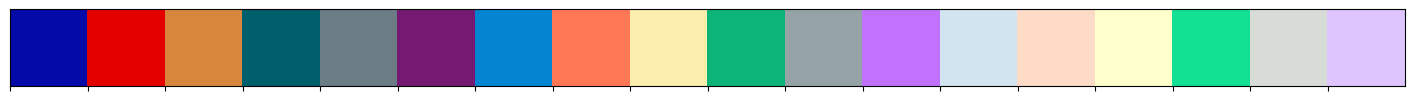

In [3]:
palette = [ "#030aa7", "#e50000", "#d8863b", "#005f6a", "#6b7c85", "#751973", 
            "#0485d1", "#ff7855", "#fbeeac", "#0cb577", "#95a3a6", "#c071fe", 
            "#d1e5f0", "#fddbc7", "#ffffcb", "#12e193", "#d8dcd6", "#dfc5fe", 
          ]
sns.palplot(sns.color_palette(palette))
plt.show()

# I. Import des données

In [5]:
df_analyse_achat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112650 entries, 0 to 112649
Data columns (total 51 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   order_id            112650 non-null  object        
 1   order_item_id       112650 non-null  int64         
 2   product_id          112650 non-null  object        
 3   seller_id           112650 non-null  object        
 4   price               112650 non-null  float64       
 5   freight_value       112650 non-null  float64       
 6   shipping_limit      112650 non-null  datetime64[us]
 7   limit               112650 non-null  float64       
 8   name_lenght         111047 non-null  float64       
 9   description_lenght  111047 non-null  float64       
 10  photos_qty          111047 non-null  float64       
 11  weight_g            112632 non-null  float64       
 12  length_cm           112632 non-null  float64       
 13  height_cm           112632 no

In [6]:
df_analyse_ventes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 68 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   order_id            99441 non-null  object        
 1   customer_id         99441 non-null  object        
 2   purchase_timestamp  99441 non-null  datetime64[us]
 3   approved_at         99281 non-null  datetime64[us]
 4   delivered_carrier   97658 non-null  datetime64[us]
 5   delivered_customer  96476 non-null  datetime64[us]
 6   estimated_delivery  99441 non-null  datetime64[us]
 7   status              99441 non-null  object        
 8   annee               99441 non-null  int32         
 9   mois                99441 non-null  int32         
 10  annee_mois          99441 non-null  int32         
 11  jour                99441 non-null  int32         
 12  annee_jour          99441 non-null  int32         
 13  jour_semaine        99441 non-null  int32     

# II. Identification des métriques, dimensions et hiérarchies pour le fichier analyse_achat

## 1. Métriques (Valeurs quantitatives, souvent agrégables) :

price : Prix du produit acheté.
freight_value : Valeur du fret pour l'expédition.
limit : Limite de livraison.
approuvee : Probabilité que la commande ait été approuvée.
envoyee : Probabilité que la commande ait été envoyée.
livree : Probabilité que la commande ait été livrée.
estimee : Probabilité que la commande ait une estimation de livraison.
weight_g : Poids du produit (en grammes).
length_cm, height_cm, width_cm : Dimensions du produit (en cm).

## 2. Dimensions (Attributs qualitatifs permettant de décrire les données) :

order_id : Identifiant unique de la commande.
order_item_id : Identifiant de l'item dans la commande (utilisé pour des commandes multiples).
product_id : Identifiant du produit acheté.
seller_id : Identifiant du vendeur.
category_name : Nom de la catégorie du produit.
customer_id : Identifiant du client ayant passé la commande.
customer_unique_id : Identifiant unique du client.
cust_zip_code, cust_city, cust_state, cust_name_state : Informations géographiques du client.
sell_zip_code, sell_city, sell_state, sell_name_state : Informations géographiques du vendeur.
purchase_timestamp : Date et heure de l'achat.
shipping_limit : Date limite d'expédition.
approved_at, delivered_carrier, delivered_customer, estimated_delivery : Dates liées à l'expédition et la livraison.
status : Statut de la commande.

## 3. Hiérarchies (Relations entre les dimensions, permettant de naviguer dans les données à différents niveaux) :

Hiérarchie temporelle :
    Année > Trimestre > Mois > Semaine > Jour > Heure
Hiérarchie géographique :
    État > Ville > Code postal
Hiérarchie produit :
    Catégorie de produit > Sous-catégorie.
    Produit > Marque.


# III. Identification des métriques, dimensions et hiérarchies pour le fichier analyse_ventes

## 1. Métriques (Valeurs quantitatives, souvent agrégables) :

approuvee : Probabilité de la commande approuvée.
envoyee : Probabilité de l'ordre envoyé.
livree : Probabilité de la commande livrée.
estimee : Probabilité de l'estimation de livraison.
int_boleto, int_credit_card, int_debit_card, int_not_defined, int_voucher : Types de paiements effectués.
value_boleto, value_credit_card, value_debit_card, value_not_defined, value_voucher : Valeurs des paiements effectués pour chaque type.
score : Probabilité globale de la commande (calculée à partir des réponses, des scores et des commentaires des clients).

## 2. Dimensions (Attributs qualitatifs permettant de décrire les données) :

order_id : Identifiant unique de la commande.
customer_id : Identifiant du client.
customer_unique_id : Identifiant unique du client (peut être un identifiant anonymisé).
status : Statut de la commande.
city, state, name_state, zip_code : Données géographiques du client (Ville, État, Code postal).
product_category : Catégorie du produit acheté.
purchase_timestamp : Date et heure d'achat.
approved_at, delivered_carrier, delivered_customer, estimated_delivery : Dates relatives à l'approbation, à l'expédition et à la livraison.
jour_semaine, semaine, mois, trimestre, annee : Découpage temporel basé sur l'année, le mois, la semaine, le jour, et le trimestre.
annee_mois, annee_semaine, annee_trimestre : Découpage temporel combinant année avec mois, semaine, et trimestre.

## 3. Hiérarchies (Relations entre les dimensions, permettant de naviguer dans les données à différents niveaux) :

Hiérarchie temporelle :
    Année > Trimestre > Mois > Semaine > Jour > Heure
Hiérarchie géographique :
    État > Ville > Code postal

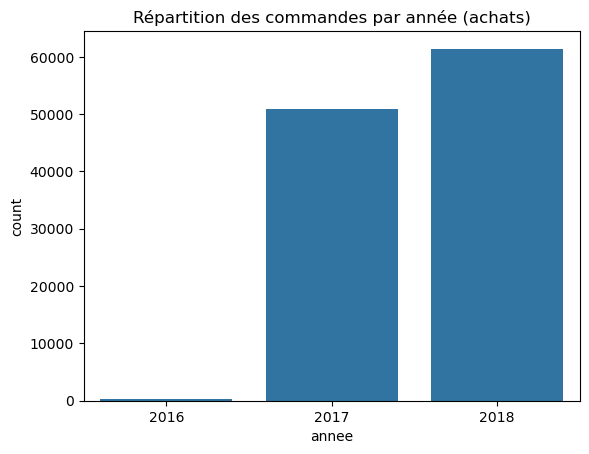

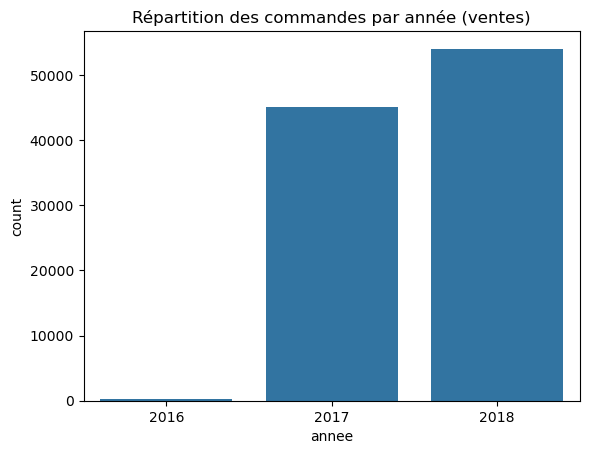

In [8]:
# Répartition des commandes achat par année
sns.countplot(x='annee', data=df_analyse_achat)
plt.title('Répartition des commandes par année (achats)')
plt.show()

# Répartition des commandes dans ventes par année
sns.countplot(x='annee', data=df_analyse_ventes)
plt.title('Répartition des commandes par année (ventes)')
plt.show()

In [9]:
# Proportion de valeurs manquantes dans `df_analyse_achat`
missing_achat = df_analyse_achat.isnull().mean() * 100
missing_achat[missing_achat > 0]
# Très peu de valeurs manquantes, je laisse le fichier tel quel

name_lenght           1.422992
description_lenght    1.422992
photos_qty            1.422992
weight_g              0.015979
length_cm             0.015979
height_cm             0.015979
width_cm              0.015979
approved_at           0.013316
delivered_carrier     1.059920
delivered_customer    2.178429
approuvee             0.013316
envoyee               1.059920
livree                2.178429
cust_lat              0.268087
cust_lng              0.268087
sell_lat              0.224589
sell_lng              0.224589
dtype: float64

In [10]:
# Proportion de valeurs manquantes dans `df_analyse_ventes`
missing_ventes = df_analyse_ventes.isnull().mean() * 100
missing_ventes[missing_ventes > 0]
# Très peu de valeurs manquantes, je laisse le fichier tel quel

approved_at           0.160899
delivered_carrier     1.793023
delivered_customer    2.981668
approuvee             0.160899
envoyee               1.793023
livree                2.981668
int_boleto            0.001006
int_credit_card       0.001006
int_debit_card        0.001006
int_not_defined       0.001006
int_voucher           0.001006
value_boleto          0.001006
value_credit_card     0.001006
value_debit_card      0.001006
value_not_defined     0.001006
value_voucher         0.001006
lat_min               0.279563
lat_max               0.279563
lat                   0.279563
lng_min               0.279563
lng_max               0.279563
lng                   0.279563
dtype: float64

In [11]:
#Verification de dates invalides achat
invalid_dates = df_analyse_achat[
    df_analyse_achat['purchase_timestamp'] > df_analyse_achat['delivered_customer']
]
invalid_dates

Empty DataFrame
Columns: [order_id, order_item_id, product_id, seller_id, price, freight_value, shipping_limit, limit, name_lenght, description_lenght, photos_qty, weight_g, length_cm, height_cm, width_cm, category_name, customer_id, purchase_timestamp, approved_at, delivered_carrier, delivered_customer, estimated_delivery, status, annee, mois, annee_mois, jour, annee_jour, jour_semaine, trimestre, annee_trimestre, semaine, annee_semaine, heure, approuvee, envoyee, livree, estimee, customer_unique_id, cust_zip_code, cust_city, cust_state, cust_name_state, cust_lat, cust_lng, sell_zip_code, sell_city, sell_state, sell_name_state, sell_lat, sell_lng]
Index: []

[0 rows x 51 columns]

In [12]:
#Verification de dates invalides vente
invalid_dates = df_analyse_ventes[
    df_analyse_ventes['purchase_timestamp'] > df_analyse_ventes['delivered_customer']
]
invalid_dates

Empty DataFrame
Columns: [order_id, customer_id, purchase_timestamp, approved_at, delivered_carrier, delivered_customer, estimated_delivery, status, annee, mois, annee_mois, jour, annee_jour, jour_semaine, trimestre, annee_trimestre, semaine, annee_semaine, heure, approuvee, envoyee, livree, estimee, int_boleto, int_credit_card, int_debit_card, int_not_defined, int_voucher, value_boleto, value_credit_card, value_debit_card, value_not_defined, value_voucher, answer_1, answer_2, answer_3, answer_4, answer_5, comment_1, comment_2, comment_3, comment_4, comment_5, creation_1, creation_2, creation_3, creation_4, creation_5, score_1, score_2, score_3, score_4, score_5, score, answer, creation, comment, customer_unique_id, zip_code, city, state, name_state, lat_min, lat_max, lat, lng_min, lng_max, lng]
Index: []

[0 rows x 68 columns]

In [13]:
state_code_map = {
    'AC': 'Acre', 'AL': 'Alagoas', 'AP': 'Amapá', 'AM': 'Amazonas', 'BA': 'Bahia',
    'CE': 'Ceará', 'DF': 'Distrito Federal', 'ES': 'Espírito Santo', 'GO': 'Goiás',
    'MA': 'Maranhão', 'MT': 'Mato Grosso', 'MS': 'Mato Grosso do Sul', 'MG': 'Minas Gerais',
    'PA': 'Pará', 'PB': 'Paraíba', 'PR': 'Paraná', 'PE': 'Pernambuco', 'PI': 'Piauí',
    'RJ': 'Rio de Janeiro', 'RN': 'Rio Grande do Norte', 'RS': 'Rio Grande do Sul',
    'RO': 'Rondônia', 'RR': 'Roraima', 'SC': 'Santa Catarina', 'SP': 'São Paulo',
    'SE': 'Sergipe', 'TO': 'Tocantins'
}

# IV. ANALYSE ACHATS

## 1. QUESTION 1 : Quels produits sont les plus populaires et dans quelles régions ?

In [16]:
# Nombre de produits uniques
unique_products = df_analyse_achat['product_id'].nunique()
print(f"Nombre total de produits différents : {unique_products}")

Nombre total de produits différents : 32951


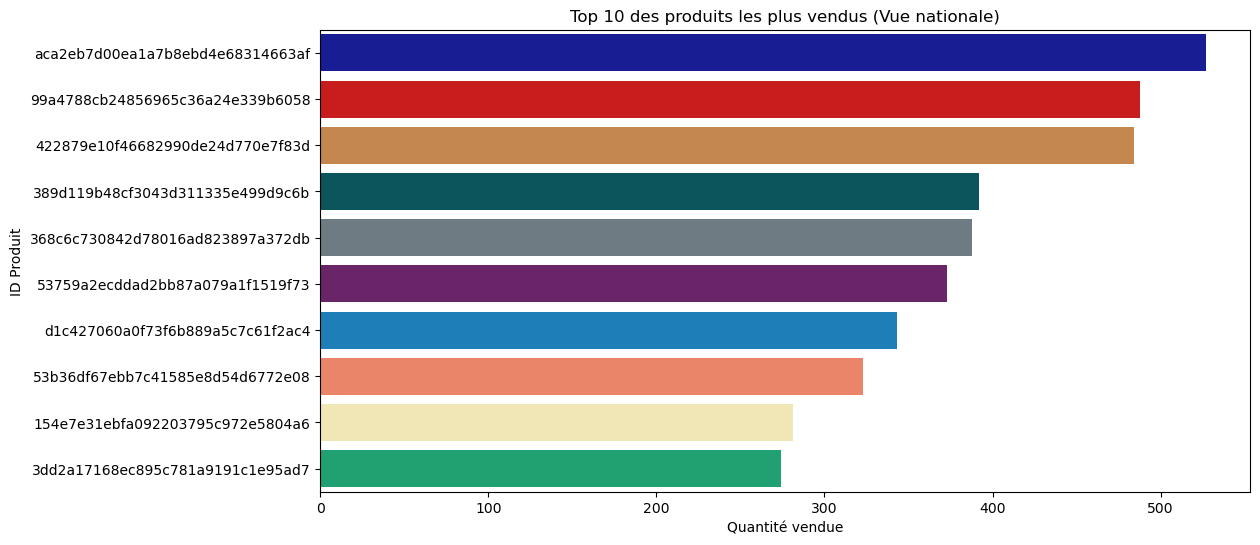

In [17]:
# Top 10 des produits les plus vendus
top_products = df_analyse_achat['product_id'].value_counts().head(10)

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 6))
sns.barplot(x=top_products.values, y=top_products.index, palette=palette)
plt.title("Top 10 des produits les plus vendus (Vue nationale)")
plt.xlabel("Quantité vendue")
plt.ylabel("ID Produit")
plt.show()

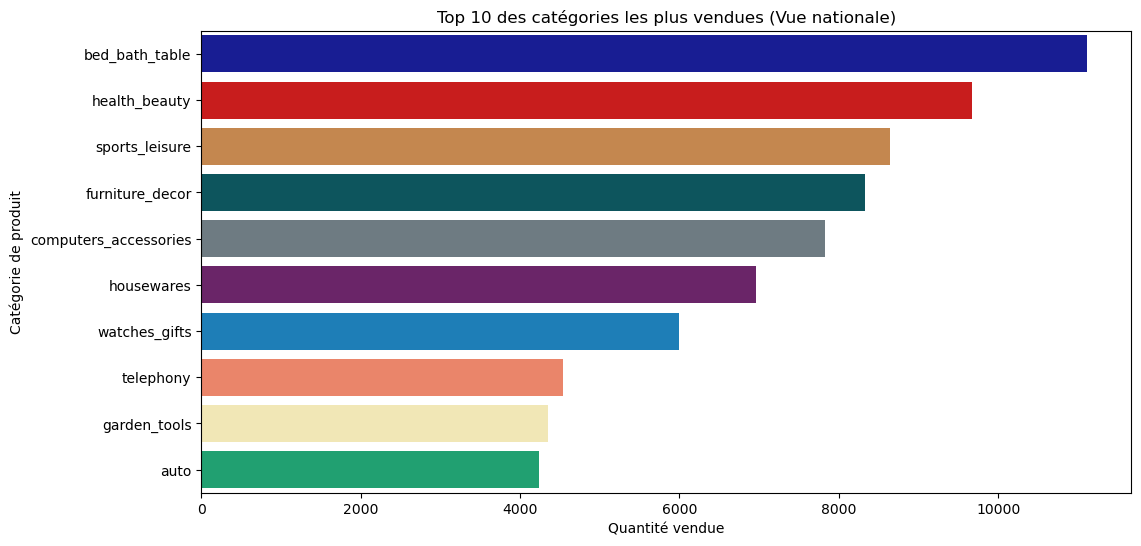

In [18]:
# Top 10 des catégories les plus vendues
top_categories = df_analyse_achat['category_name'].value_counts().head(10)

plt.figure(figsize=(12, 6))
sns.barplot(x=top_categories.values, y=top_categories.index, palette=palette)
plt.title("Top 10 des catégories les plus vendues (Vue nationale)")
plt.xlabel("Quantité vendue")
plt.ylabel("Catégorie de produit")
plt.show()

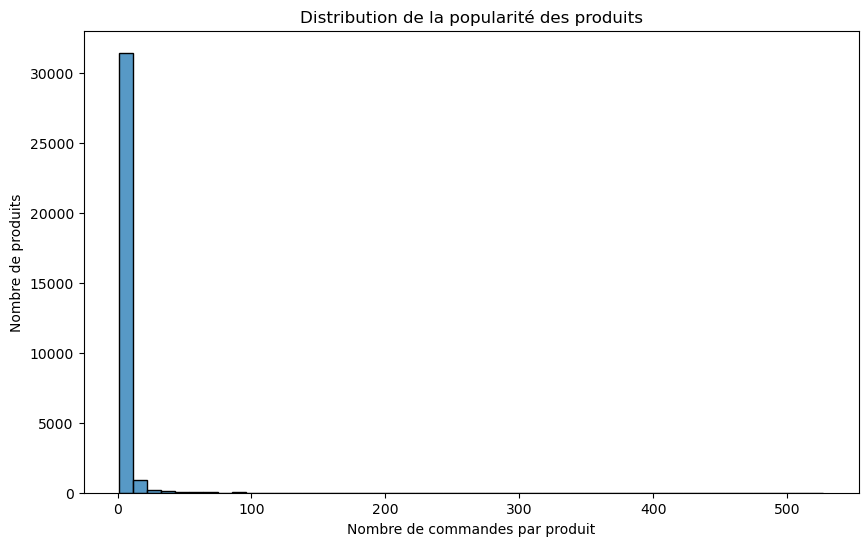

In [19]:
# Distribution du nombre de commandes par produit
product_counts = df_analyse_achat['product_id'].value_counts()

plt.figure(figsize=(10, 6))
sns.histplot(product_counts, kde=False, bins=50)
plt.title("Distribution de la popularité des produits")
plt.xlabel("Nombre de commandes par produit")
plt.ylabel("Nombre de produits")
plt.show()

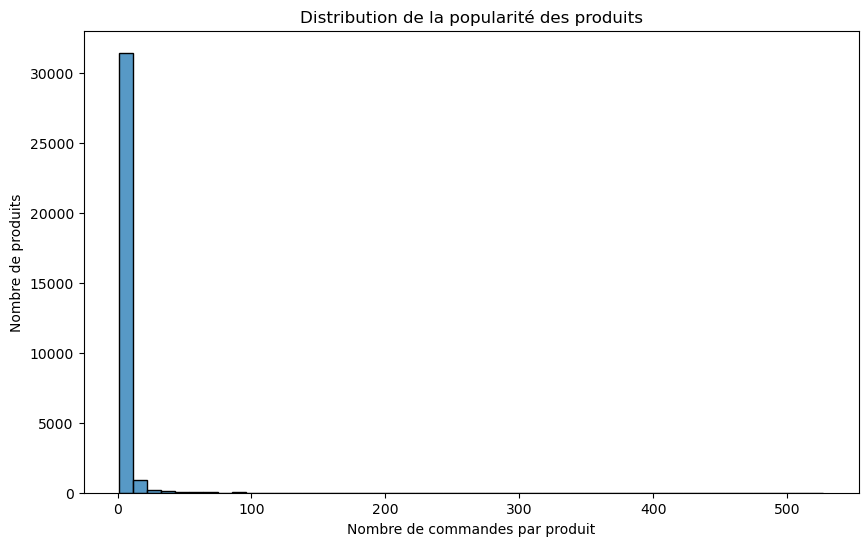

In [20]:
# On ne voit pas beaucoup la différence, j'ai ajouté un yscale pour mieux voir
# Distribution du nombre de commandes par produit
product_counts = df_analyse_achat['product_id'].value_counts()

plt.figure(figsize=(10, 6))
sns.histplot(product_counts, kde=False, bins=50)
plt.title("Distribution de la popularité des produits")
plt.xlabel("Nombre de commandes par produit")
plt.ylabel("Nombre de produits")
plt.show()

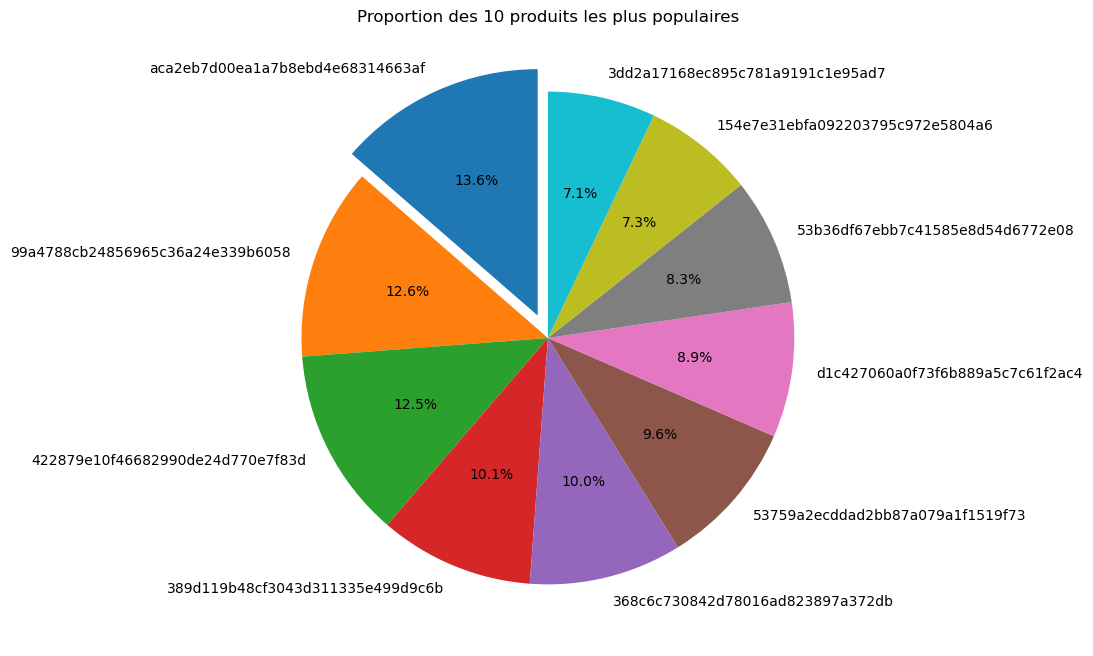

In [21]:
# Top 10 produits les plus populaires
top_10_products = product_counts.head(10)

plt.figure(figsize=(8, 8))
top_10_products.plot.pie(
    autopct='%1.1f%%', startangle=90,
    explode=[0.1] + [0]*9
)
plt.title("Proportion des 10 produits les plus populaires")
plt.ylabel("")
plt.show()

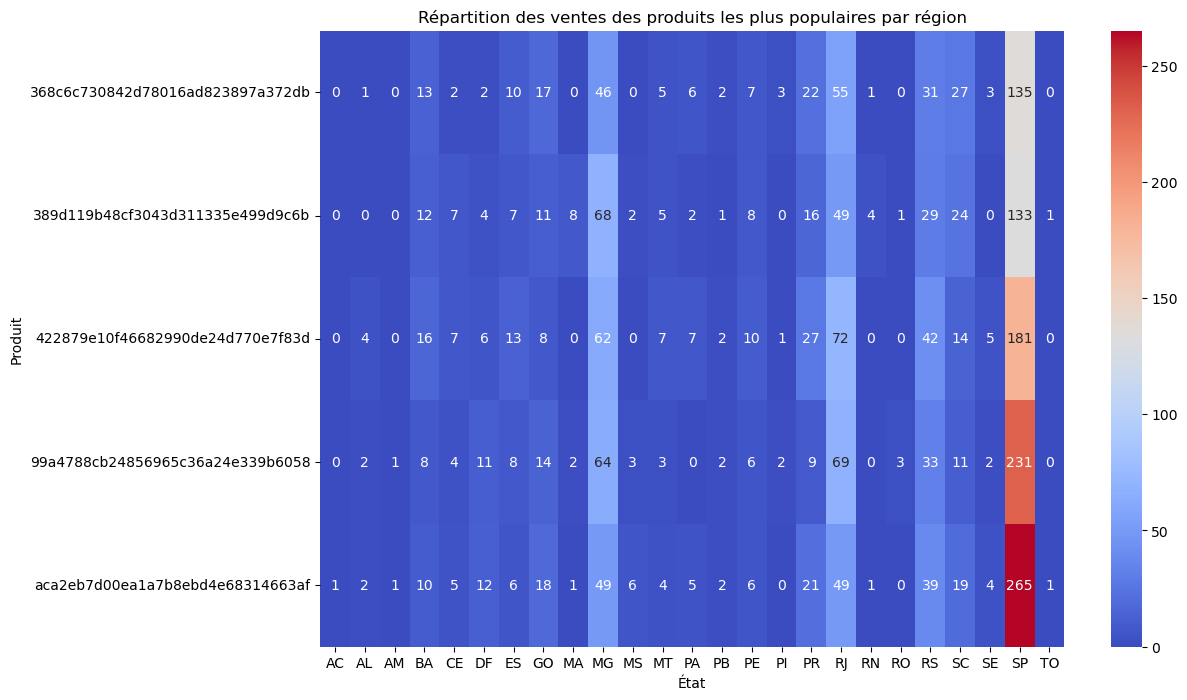

In [22]:
# Top 5 produits les plus populaires
top_5_products = product_counts.head(5).index
top_products_region = df_analyse_achat[df_analyse_achat['product_id'].isin(top_5_products)]
product_region_counts = top_products_region.groupby(['product_id', 'cust_state']).size().unstack(fill_value=0)

# Heatmap des ventes par produit et région
plt.figure(figsize=(12, 8))
sns.heatmap(product_region_counts, cmap="coolwarm", annot=True, fmt="d", cbar=True)
plt.title("Répartition des ventes des produits les plus populaires par région")
plt.xlabel("État")
plt.ylabel("Produit")
plt.show()

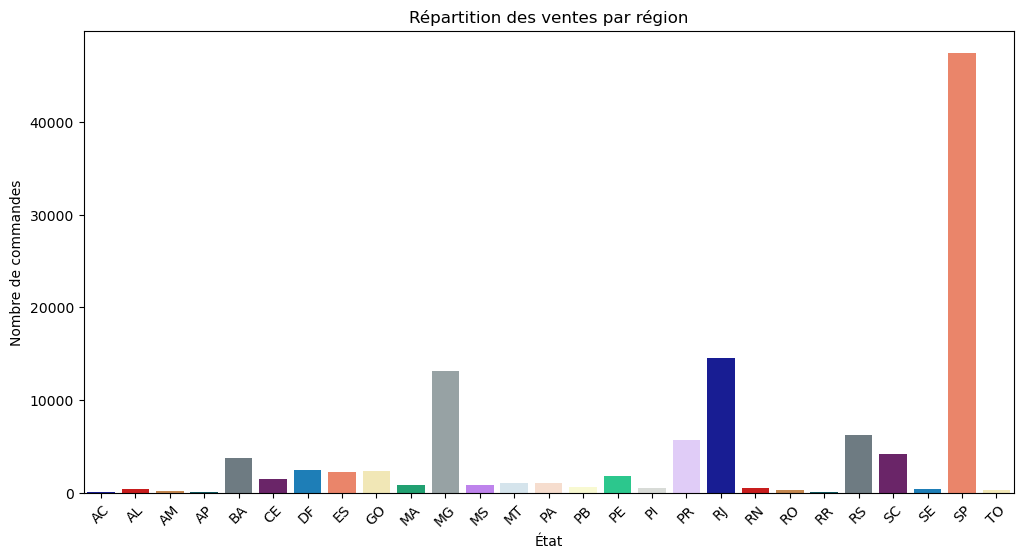

In [23]:
# Agrégation des ventes par région
region_sales = df_analyse_achat.groupby('cust_state').size()

# Répartition des ventes par région
plt.figure(figsize=(12, 6))
sns.barplot(x=region_sales.index, y=region_sales.values, palette=palette)
plt.title("Répartition des ventes par région")
plt.xlabel("État")
plt.ylabel("Nombre de commandes")
plt.xticks(rotation=45)
plt.show()

<Figure size 1200x800 with 0 Axes>

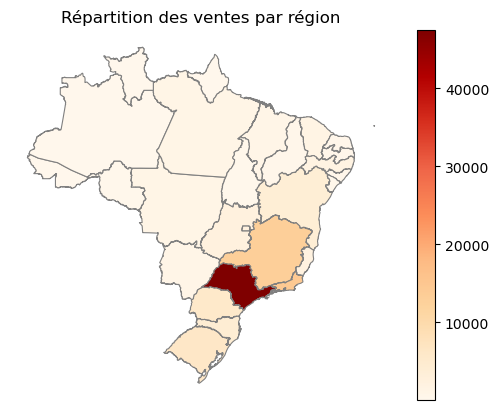

In [24]:
# Répartition des ventes par région, version carte géographique
url_geojson = "https://raw.githubusercontent.com/codeforgermany/click_that_hood/master/public/data/brazil-states.geojson"
brazil_map = gpd.read_file(url_geojson)

region_sales = df_analyse_achat.groupby('cust_state').size().reset_index()
region_sales.columns = ['state', 'num_orders']

region_sales['state_name'] = region_sales['state'].map(state_code_map)

brazil_map = brazil_map.merge(region_sales, left_on="name", right_on="state_name", how="left")

plt.figure(figsize=(12, 8))
brazil_map.plot(
    column='num_orders', cmap='OrRd', linewidth=0.8, edgecolor='grey', legend=True,
    missing_kwds={'color': 'lightgrey', 'label': 'Données manquantes'}
)

plt.title("Répartition des ventes par région")
plt.axis("off")
plt.show()

## Conclusion

En tout il y a 32951 produits différents.
Le produit le plus populaire est aca2eb7dOOea1a7b8ebd4e68314663af, il a été vendu plus de 500x.
Les autres 9 produits les plus populaires sont vendus 200x ou plus.
Parmi les 10 produits les plus populaires aca2eb7dOOea1a7b8ebd4e68314663af représente presque 14% des ventes.

Les produits de lit et bain sont la catégorie la plus populaire, suivie par les produits de beauté et de soin ainsi que les produits de sport et loisirs.

La région qui a acheté le plus de ces produits est de très loin Sao Paulo (SP), suivie de Rio de Janeiro (RJ) et de Minas Gerais (MG), tous situés dans le sud du Brésil.

## 2. QUESTION 2 : Quels facteurs influencent le délai de livraison ?

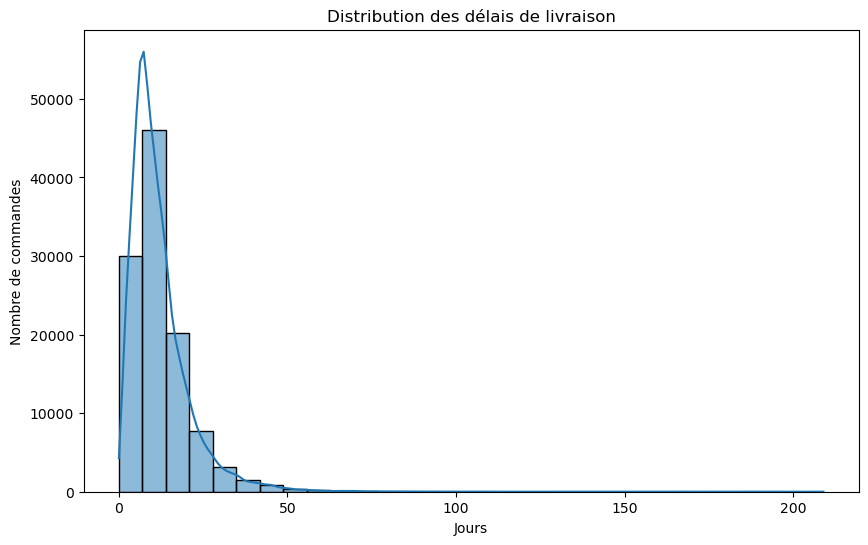

In [171]:
# Calcul des délais
df_analyse_achat['delivery_time'] = (
    df_analyse_achat['delivered_customer'] - df_analyse_achat['purchase_timestamp']
).dt.days

# Distribution des délais de livraison
plt.figure(figsize=(10, 6))
sns.histplot(df_analyse_achat['delivery_time'].dropna(), kde=True, bins=30)
plt.title("Distribution des délais de livraison")
plt.xlabel("Jours")
plt.ylabel("Nombre de commandes")
plt.show()

In [28]:
# Calcul des délais de livraison en jours
df_analyse_achat['delivery_time'] = (
    df_analyse_achat['delivered_customer'] - df_analyse_achat['purchase_timestamp']
).dt.days

# Agréger les délais moyens par région
delivery_time_by_state = df_analyse_achat.groupby('cust_state')['delivery_time'].mean().reset_index()
delivery_time_by_state.columns = ['state', 'avg_delivery_time']

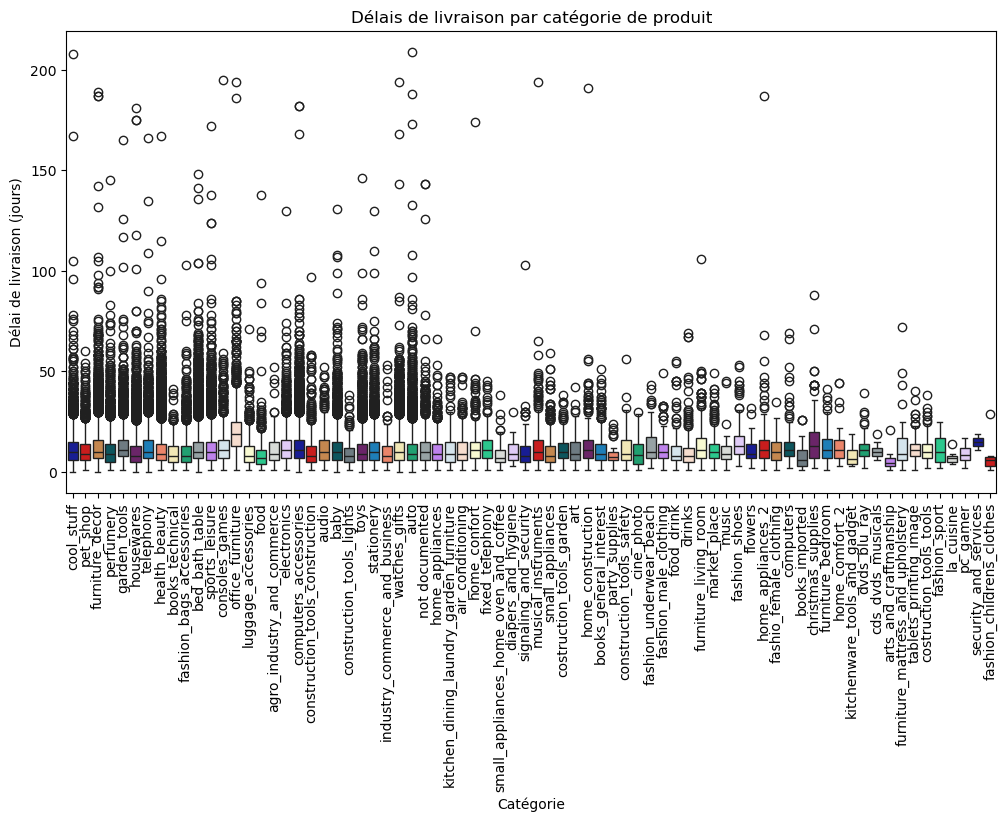

In [29]:
# Délais de livraison en jours par catégorie
plt.figure(figsize=(12, 6))
sns.boxplot(x='category_name', y='delivery_time', data=df_analyse_achat, palette=palette)
plt.title("Délais de livraison par catégorie de produit")
plt.xlabel("Catégorie")
plt.ylabel("Délai de livraison (jours)")
plt.xticks(rotation=90)
plt.show()

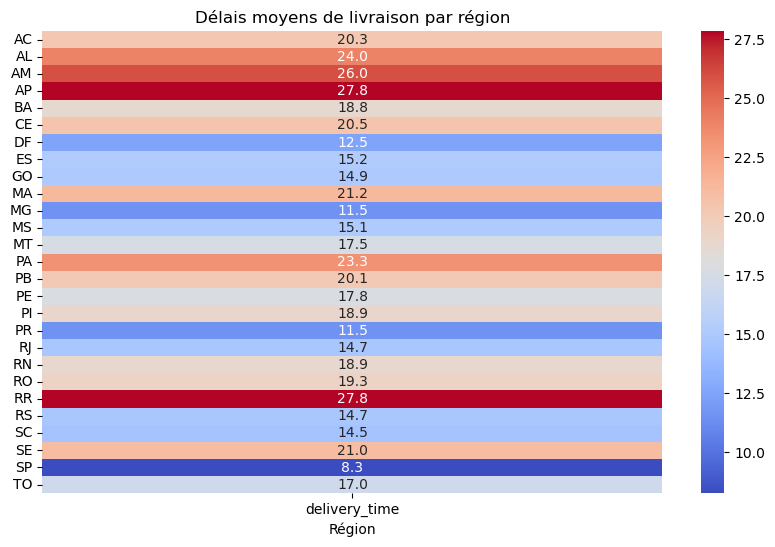

In [30]:
# Délais de livraison moyen par région
region_delivery = df_analyse_achat.groupby('cust_state')['delivery_time'].mean().reset_index()
plt.figure(figsize=(10, 6))
sns.heatmap(region_delivery.pivot_table(index='cust_state', values='delivery_time'),
            cmap="coolwarm", annot=True, fmt=".1f", cbar=True)
plt.title("Délais moyens de livraison par région")
plt.xlabel("Région")
plt.ylabel("")
plt.show()

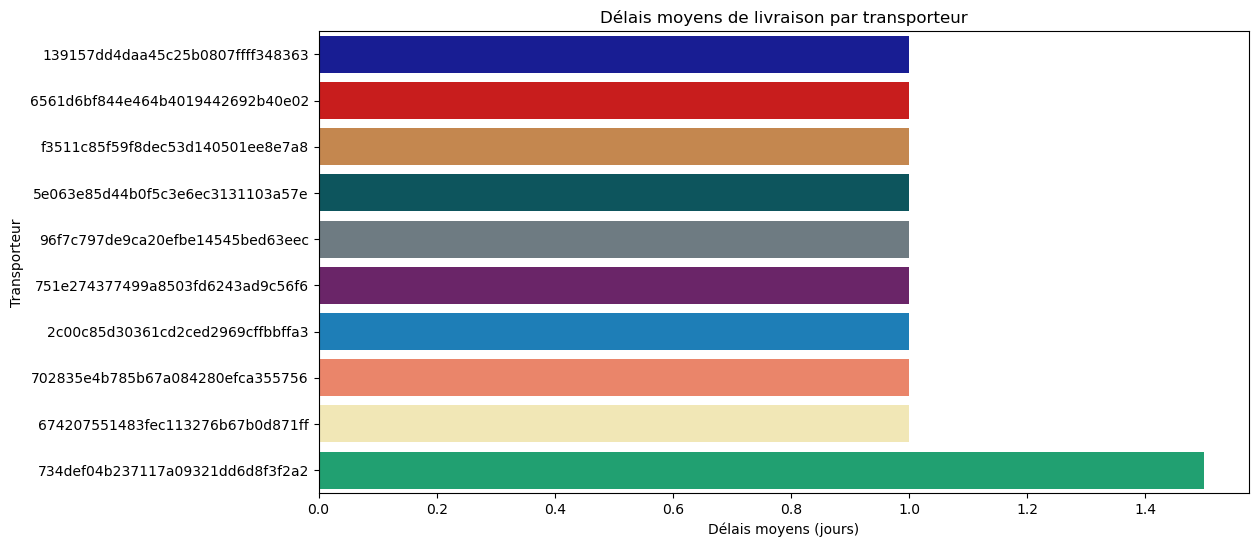

In [31]:
# Délais de liraison moyen par transporteur
carrier_delivery = df_analyse_achat.groupby('seller_id')['delivery_time'].mean().reset_index()
top_carriers = carrier_delivery.sort_values(by='delivery_time', ascending=True).head(10)

plt.figure(figsize=(12, 6))
sns.barplot(x='delivery_time', y='seller_id', data=top_carriers, palette=palette)
plt.title("Délais moyens de livraison par transporteur")
plt.xlabel("Délais moyens (jours)")
plt.ylabel("Transporteur")
plt.show()

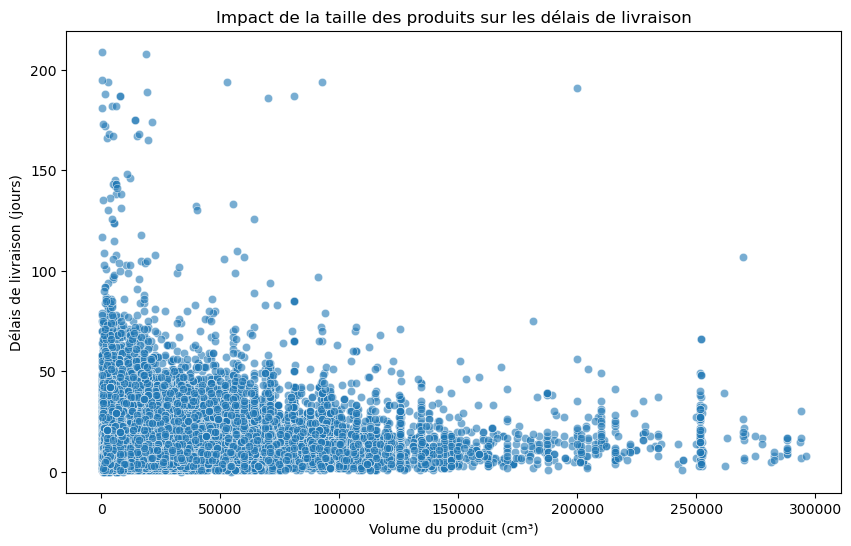

In [32]:
# Délais de livraison suivant la taille des produits
df_analyse_achat['volume'] = (
    df_analyse_achat['length_cm'] * df_analyse_achat['width_cm'] * df_analyse_achat['height_cm']
)

plt.figure(figsize=(10, 6))
sns.scatterplot(x='volume', y='delivery_time', data=df_analyse_achat, alpha=0.6)
plt.title("Impact de la taille des produits sur les délais de livraison")
plt.xlabel("Volume du produit (cm³)")
plt.ylabel("Délais de livraison (jours)")
plt.show()

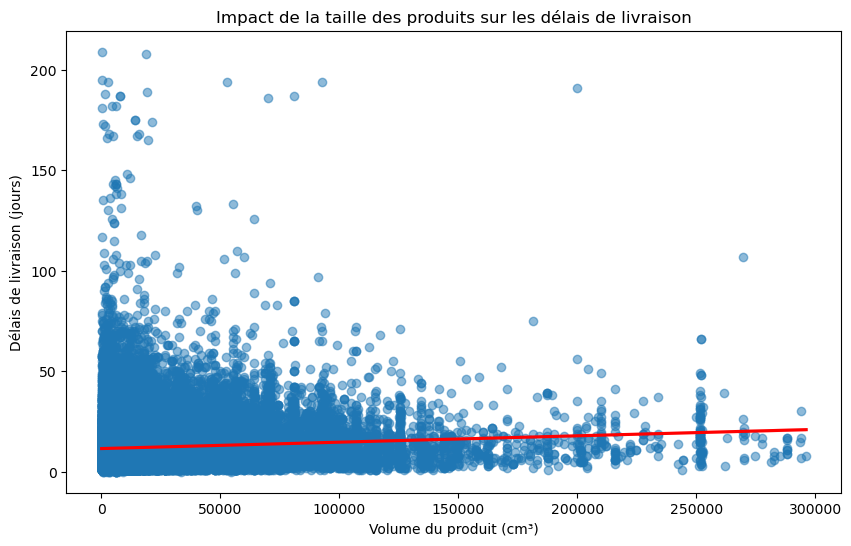

In [33]:
df_analyse_achat['delivery_time'] = (df_analyse_achat['delivered_customer'] - df_analyse_achat['purchase_timestamp']).dt.days
df_analyse_achat['volume'] = df_analyse_achat['length_cm'] * df_analyse_achat['width_cm'] * df_analyse_achat['height_cm']

plt.figure(figsize=(10, 6))
sns.regplot(x='volume', y='delivery_time', data=df_analyse_achat, scatter_kws={'alpha':0.5}, line_kws={"color": "red"})
plt.title("Impact de la taille des produits sur les délais de livraison")
plt.xlabel("Volume du produit (cm³)")
plt.ylabel("Délais de livraison (jours)")
plt.show()

In [34]:
correlation = df_analyse_achat[['volume', 'delivery_time']].corr()
print("Coefficient de corrélation :\n", correlation)

Coefficient de corrélation :
                  volume  delivery_time
volume         1.000000       0.078019
delivery_time  0.078019       1.000000


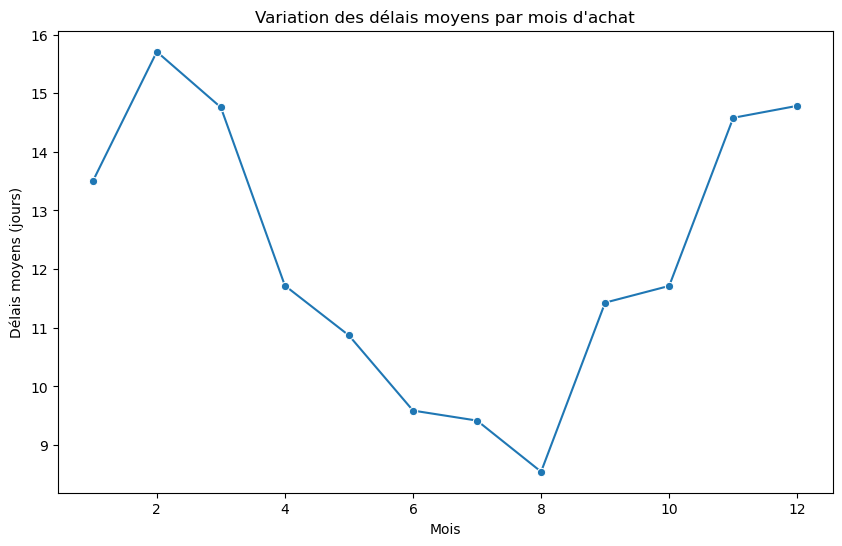

In [35]:
# Variation des délais moyens par mois d'achat
df_analyse_achat['month'] = df_analyse_achat['purchase_timestamp'].dt.month
monthly_delivery = df_analyse_achat.groupby('month')['delivery_time'].mean().reset_index()

plt.figure(figsize=(10, 6))
sns.lineplot(x='month', y='delivery_time', data=monthly_delivery, marker="o")
plt.title("Variation des délais moyens par mois d'achat")
plt.xlabel("Mois")
plt.ylabel("Délais moyens (jours)")
plt.show()

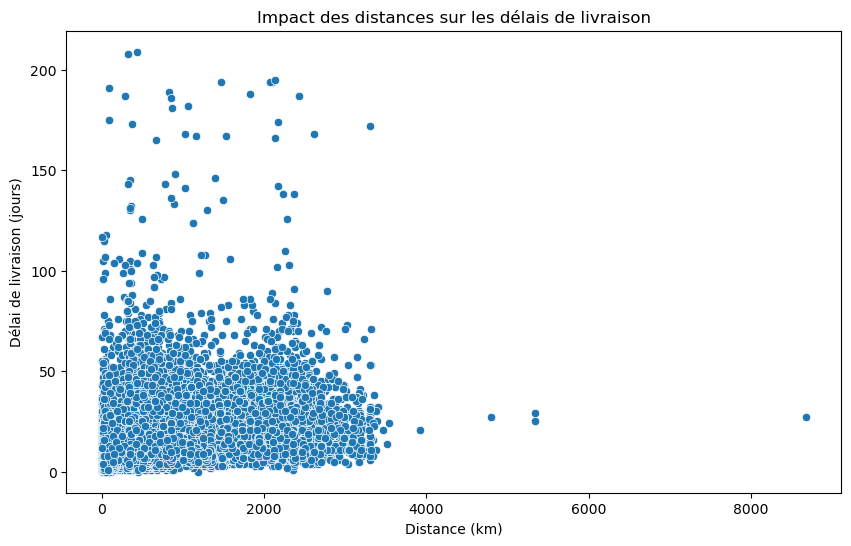

In [36]:
# Distance approximative (Haversine simplifiée)
def haversine(lat1, lon1, lat2, lon2):
    R = 6371  # rayon de la Terre en km
    lat1, lat2, lon1, lon2 = map(np.radians, [lat1, lat2, lon1, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    return 2 * R * np.arcsin(np.sqrt(a))

df_analyse_achat['distance'] = haversine(
    df_analyse_achat['cust_lat'], df_analyse_achat['cust_lng'],
    df_analyse_achat['sell_lat'], df_analyse_achat['sell_lng']
)

plt.figure(figsize=(10, 6))
sns.scatterplot(x='distance', y='delivery_time', data=df_analyse_achat)
plt.title("Impact des distances sur les délais de livraison")
plt.xlabel("Distance (km)")
plt.ylabel("Délai de livraison (jours)")
plt.show()

## Conclusion

La majorité des commandes est livrée dans les 50 jours.
La catégorie des produits n'a pas un impact significatif sur la durée de livraison. On remarque cependant que certains produits sont plus longs à être livrés comme les autos, décorations et fournitures de bureau
Les régions Roraima (RR) et Amapá (AP), Amazonas (AM), et Alagoas (AL) sont les régions dans lesquels les délais moyens de livraison sont les plus longs (+24 jours).

le transporteur 734def04b237117a09321dd6d8f3f2a2 a le délais moyen le plus long, cela peut avoir un impact sur la livraison.
Le volume des produits n'a pas un impact significatif sur la durée de livraison.
La période hivernale peut doubler le temps de livraison des produits.
Finalement la distance non plus n'a pas un impact significatif sur le temps de livaison.


## 3. QUESTION 3 : Quels produits ont les meilleures descriptions, photos ?

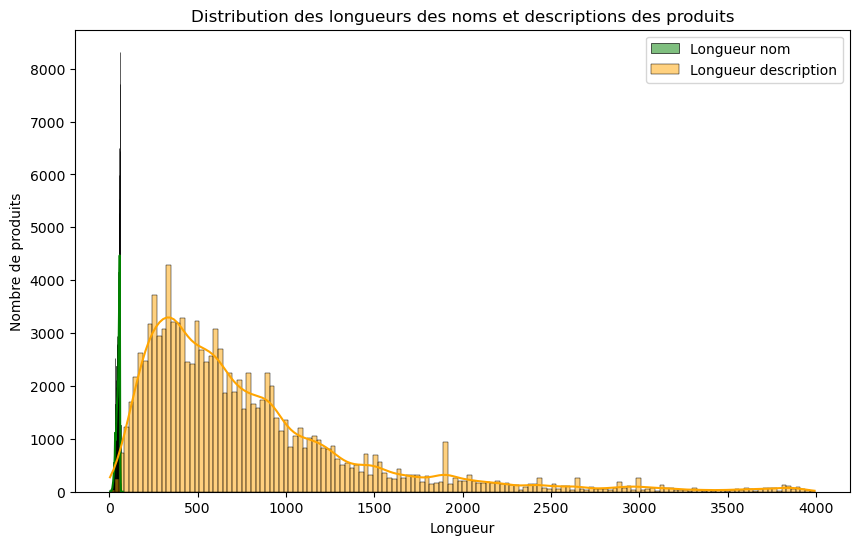

In [39]:
# Longueur des noms et descriptions de produits
plt.figure(figsize=(10, 6))
sns.histplot(df_analyse_achat['name_lenght'].dropna(), kde=True, color="green", label="Longueur nom")
sns.histplot(df_analyse_achat['description_lenght'].dropna(), kde=True, color="orange", label="Longueur description")
plt.title("Distribution des longueurs des noms et descriptions des produits")
plt.xlabel("Longueur")
plt.ylabel("Nombre de produits")
plt.legend()
plt.show()

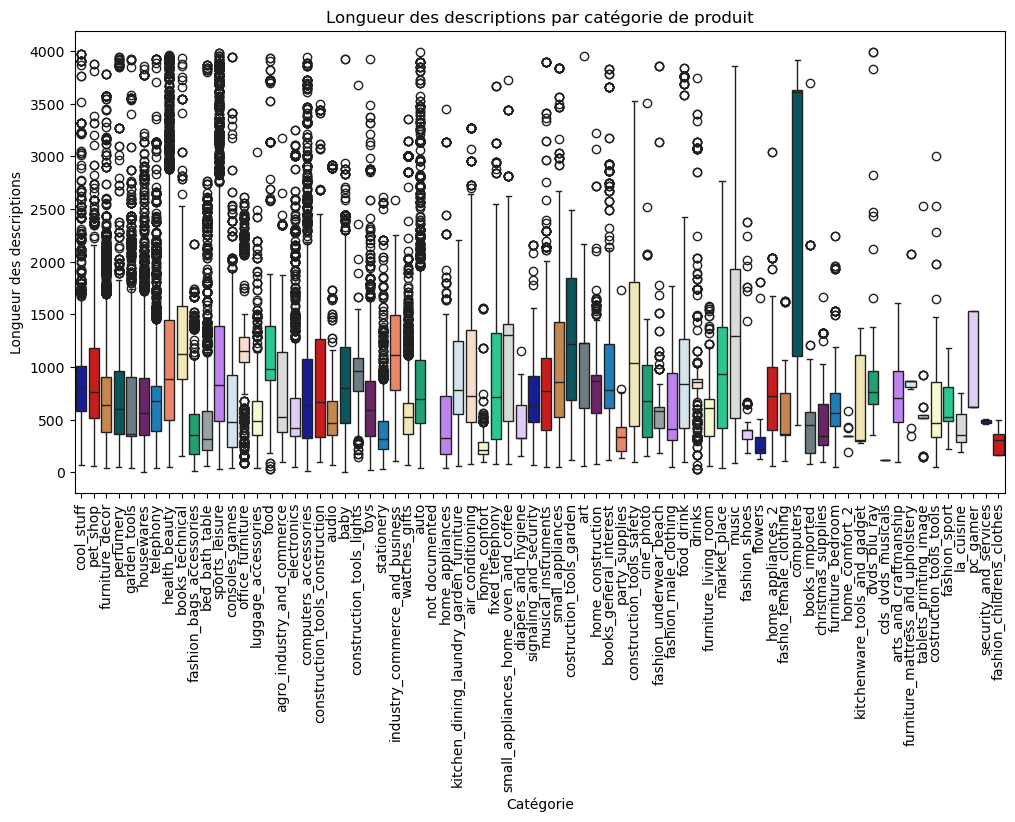

In [40]:
# Longueur des descriptions par catégories
plt.figure(figsize=(12, 6))
sns.boxplot(x='category_name', y='description_lenght', data=df_analyse_achat, palette=palette)
plt.title("Longueur des descriptions par catégorie de produit")
plt.xlabel("Catégorie")
plt.ylabel("Longueur des descriptions")
plt.xticks(rotation=90)
plt.show()

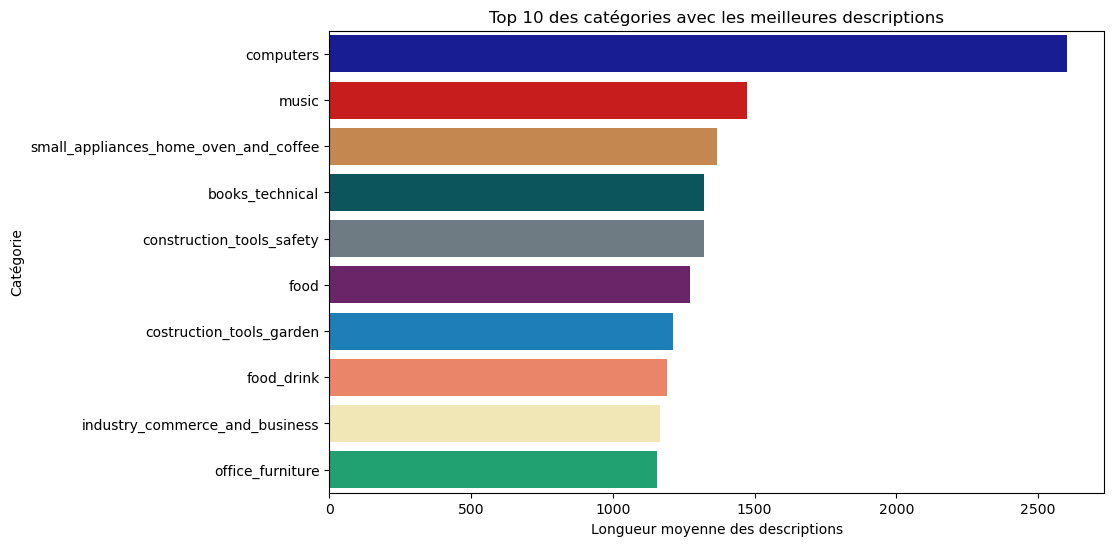

In [41]:
# Top 10 des catégories avec les meilleures descriptions
category_avg_desc = df_analyse_achat.groupby('category_name')['description_lenght'].mean().sort_values(ascending=False).head(10)

plt.figure(figsize=(10, 6))
sns.barplot(x=category_avg_desc.values, y=category_avg_desc.index, palette=palette)
plt.title("Top 10 des catégories avec les meilleures descriptions")
plt.xlabel("Longueur moyenne des descriptions")
plt.ylabel("Catégorie")
plt.show()

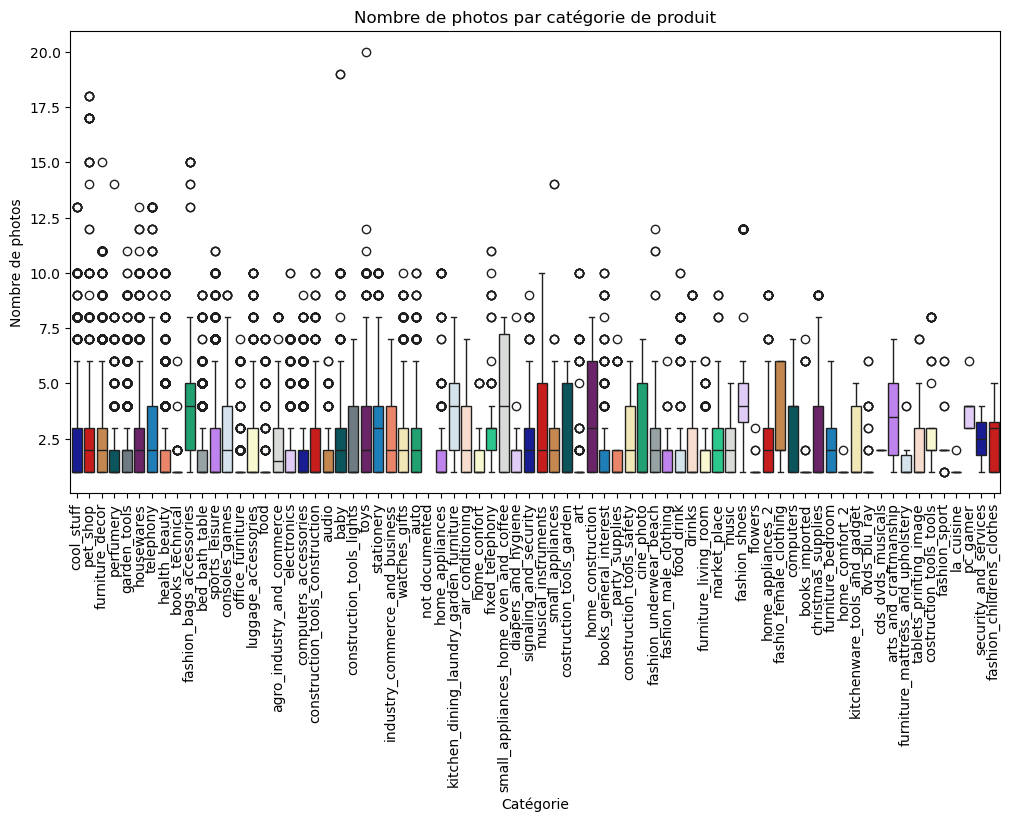

In [42]:
# Nombre de photos par catégorie
plt.figure(figsize=(12, 6))
sns.boxplot(x='category_name', y='photos_qty', data=df_analyse_achat, palette=palette)
plt.title("Nombre de photos par catégorie de produit")
plt.xlabel("Catégorie")
plt.ylabel("Nombre de photos")
plt.xticks(rotation=90)
plt.show()

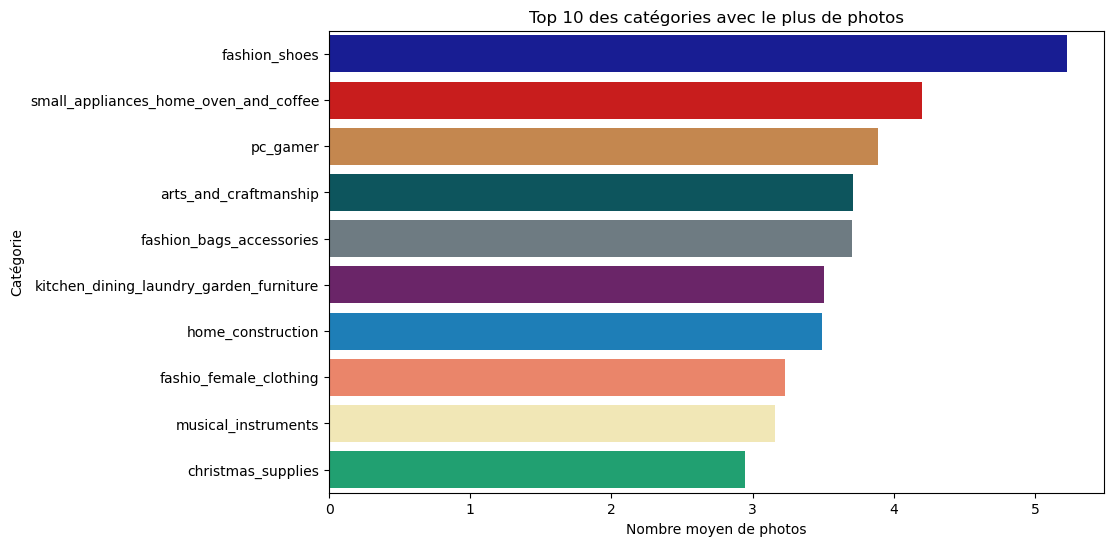

In [43]:
# Top 10 des catégories avec le plus de photos
category_avg_photos = df_analyse_achat.groupby('category_name')['photos_qty'].mean().sort_values(ascending=False).head(10)

plt.figure(figsize=(10, 6))
sns.barplot(x=category_avg_photos.values, y=category_avg_photos.index, palette=palette)
plt.title("Top 10 des catégories avec le plus de photos")
plt.xlabel("Nombre moyen de photos")
plt.ylabel("Catégorie")
plt.show()

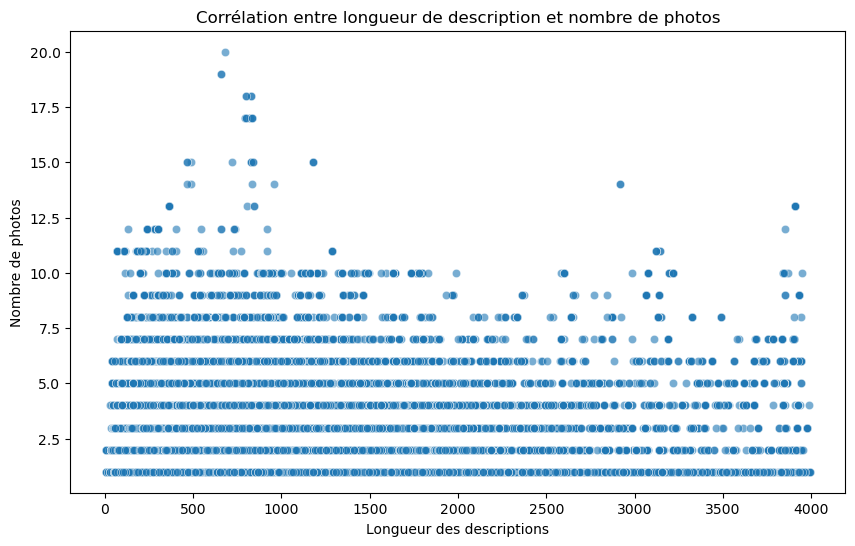

In [44]:
# Corrélation entre longueur de description et nombre de photos
plt.figure(figsize=(10, 6))
sns.scatterplot(x='description_lenght', y='photos_qty', data=df_analyse_achat, alpha=0.6)
plt.title("Corrélation entre longueur de description et nombre de photos")
plt.xlabel("Longueur des descriptions")
plt.ylabel("Nombre de photos")
plt.show()

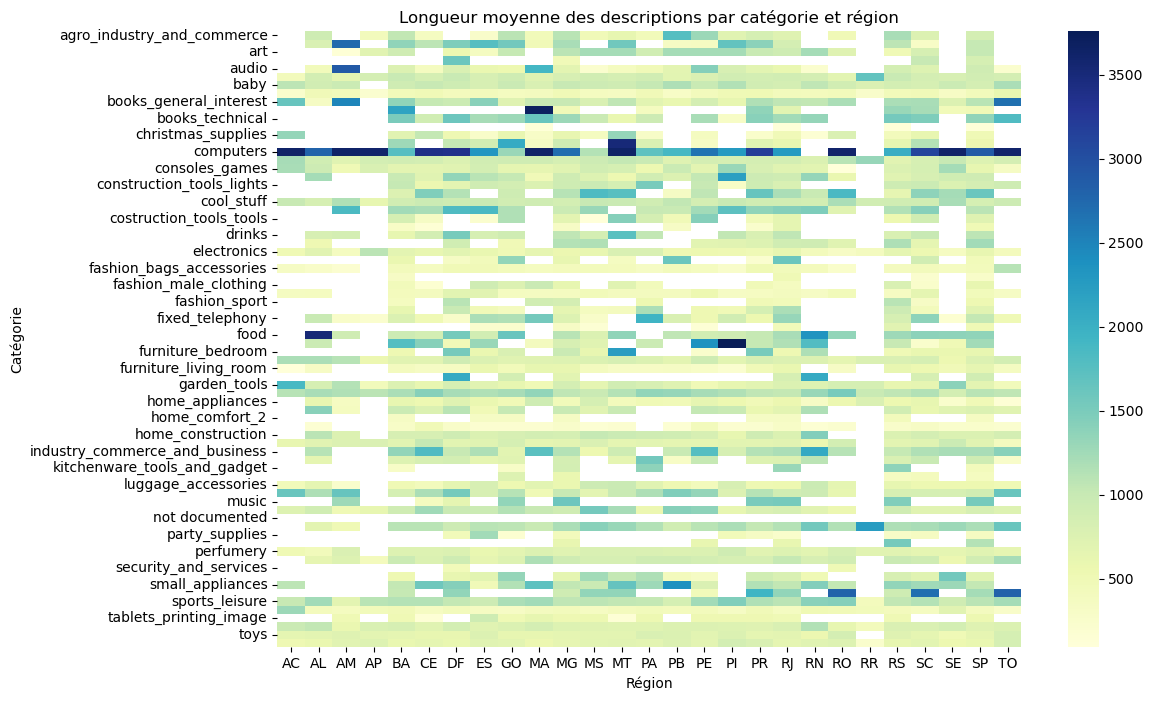

In [45]:
# Longueur moyenne des description par catégorie par région
category_region = df_analyse_achat.groupby(['category_name', 'cust_state'])['description_lenght'].mean().unstack()

plt.figure(figsize=(12, 8))
sns.heatmap(category_region, cmap="YlGnBu", annot=False, cbar=True)
plt.title("Longueur moyenne des descriptions par catégorie et région")
plt.xlabel("Région")
plt.ylabel("Catégorie")
plt.show()

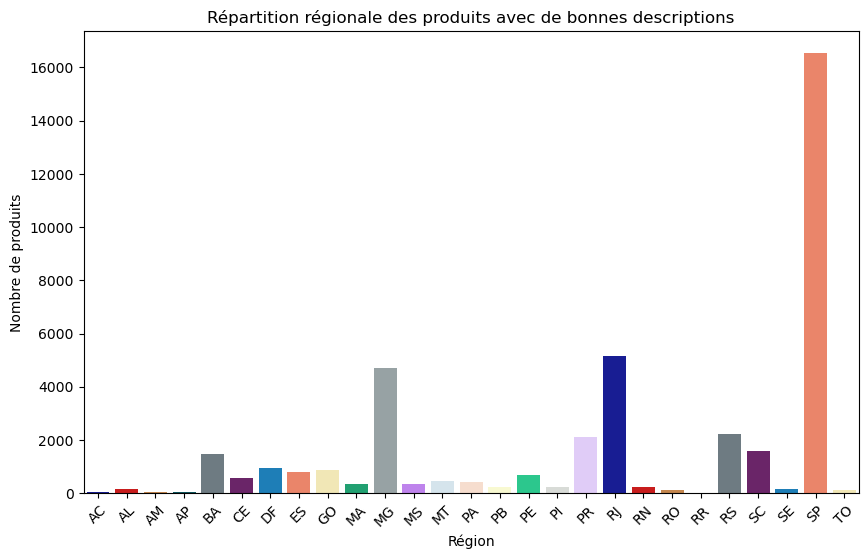

In [46]:
# Répartition régionale des produits avec de bonnes descriptions
high_desc = df_analyse_achat[df_analyse_achat['description_lenght'] > df_analyse_achat['description_lenght'].mean()]

region_high_desc = high_desc.groupby('cust_state').size()

plt.figure(figsize=(10, 6))
sns.barplot(x=region_high_desc.index, y=region_high_desc.values, palette=palette)
plt.title("Répartition régionale des produits avec de bonnes descriptions")
plt.xlabel("Région")
plt.ylabel("Nombre de produits")
plt.xticks(rotation=45)
plt.show()

In [47]:
# Calcul du nombre de ventes par produit
product_sales = df_analyse_achat['product_id'].value_counts()

# Ajout des ventes au dataframe des achats
df_analyse_achat['sales'] = df_analyse_achat['product_id'].map(product_sales)

# Calcul de la corrélation
correlation_matrix = df_analyse_achat[['sales', 'description_lenght', 'photos_qty']].corr()
correlation_matrix

sales  description_lenght  photos_qty
sales               1.000000           -0.032815    0.015990
description_lenght -0.032815            1.000000    0.118087
photos_qty          0.015990            0.118087    1.000000

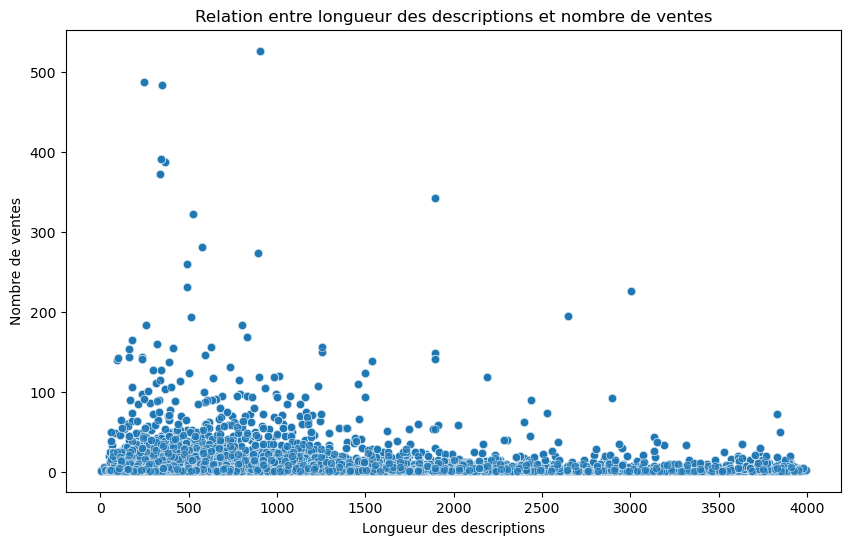

In [48]:
# Relation entre longueur des descriptions et nombre de ventes
plt.figure(figsize=(10, 6))
sns.scatterplot(x='description_lenght', y='sales', data=df_analyse_achat, alpha=0.6)
plt.title("Relation entre longueur des descriptions et nombre de ventes")
plt.xlabel("Longueur des descriptions")
plt.ylabel("Nombre de ventes")
plt.show()

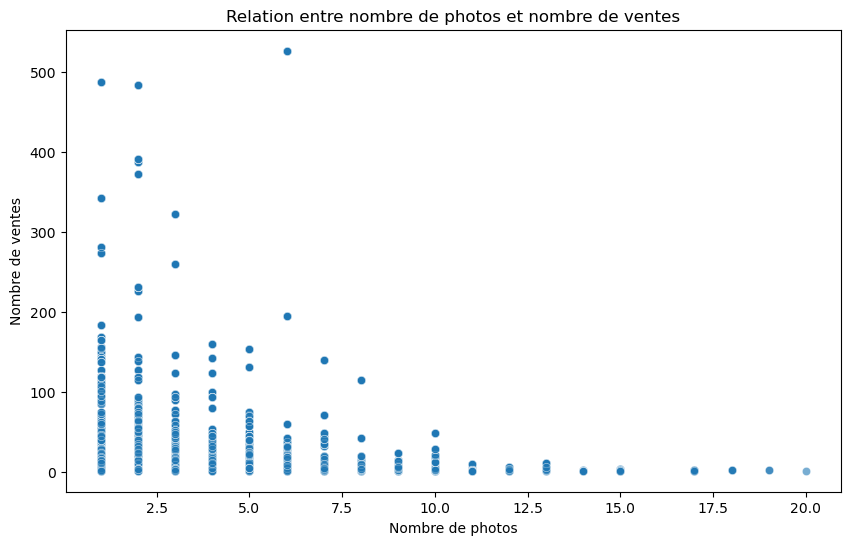

In [49]:
# Relation entre nombre de photos et nombre de ventes
plt.figure(figsize=(10, 6))
sns.scatterplot(x='photos_qty', y='sales', data=df_analyse_achat, alpha=0.6)
plt.title("Relation entre nombre de photos et nombre de ventes")
plt.xlabel("Nombre de photos")
plt.ylabel("Nombre de ventes")
plt.show()

In [50]:
# Corrélation entre 'description_lenght' et 'sales' pour la catégorie 'computers'
df_computers = df_analyse_achat[df_analyse_achat['category_name'] == 'computers']
product_sales_computers = df_computers['product_id'].value_counts()
df_computers['sales'] = df_computers['product_id'].map(product_sales_computers)
correlation = df_computers[['description_lenght', 'sales']].corr()
correlation

description_lenght     sales
description_lenght            1.000000  0.352591
sales                         0.352591  1.000000

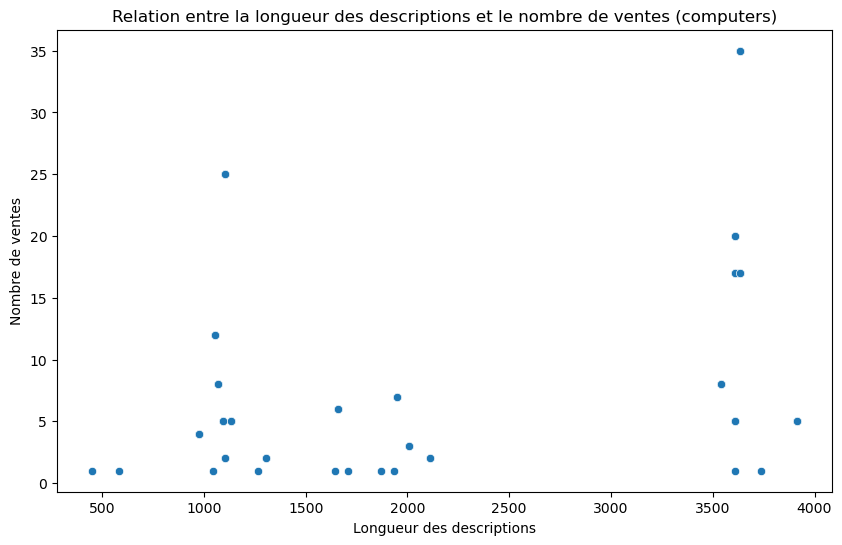

In [51]:
# Relation entre la longueur des descriptions et le nombre de ventes (computers)
plt.figure(figsize=(10, 6))
sns.scatterplot(x='description_lenght', y='sales', data=df_computers)
plt.title("Relation entre la longueur des descriptions et le nombre de ventes (computers)")
plt.xlabel("Longueur des descriptions")
plt.ylabel("Nombre de ventes")
plt.show()

## Conclusion

Beaucoup de produits ont une description allant proche de 400 à 500 caractères.
Ce sont les ordinateurs qui ont une description la plus étoffée en terme de caractères.
Les ordinateurs ainsi que produits musicaux, petit appareils éléctroménagers ou livres sont les produits avec les meilleures descriptions.
Les jouets, produits éléctroniques pour maison et les objets de mode accessoires et sacs comportent en moyenne le plus de photos
Les produits avec des hautes descriptions se retrouvent dans les régions Sao Paulo (SP), suivie de Rio de Janeiro (RJ) et de Minas Gerais (MG) avec une très nette dominance pour Sao Pa
ulo.
Il n'y a pas de forte relation entre le nombre de ventes de produits et la longueur de leur description, ni leur nombre de photos.
Cependant des ordinateurs avec des descriptions complètes de plus de 3500 caractères combinent près d'une centaines de ventes: suivant les produits, il est judicieux d'avoir une description correcte.

# V. ANALYSE VENTES

## 1. QUESTION 1 : Quels sont les profils des clients les plus fidèles ?

In [55]:
# Nombre total de commandes par client unique
customer_orders = df_analyse_ventes.groupby('customer_unique_id')['order_id'].count().reset_index()
customer_orders.columns = ['customer_unique_id', 'order_count']
df_analyse_ventes = df_analyse_ventes.merge(customer_orders, on='customer_unique_id', how='left')

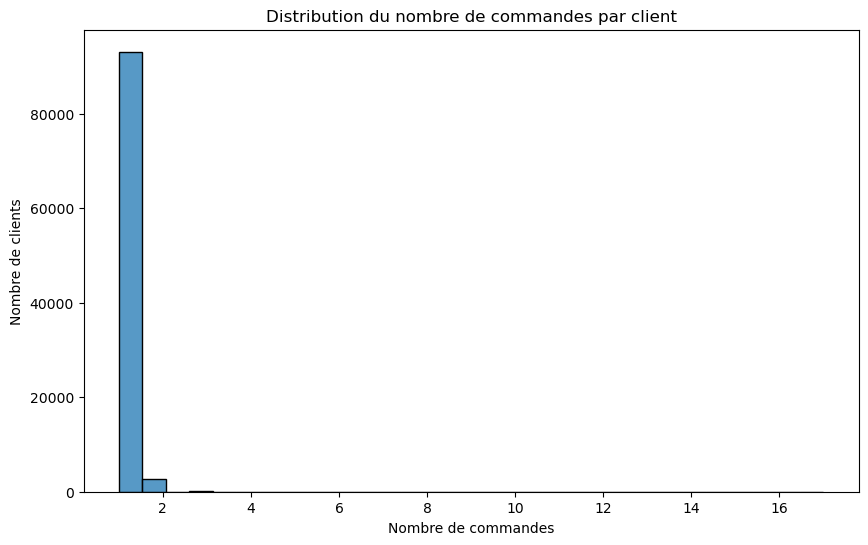

In [56]:
# Distribution du nombre de commandes par client
plt.figure(figsize=(10, 6))
sns.histplot(customer_orders['order_count'], bins=30, kde=False)
plt.title("Distribution du nombre de commandes par client")
plt.xlabel("Nombre de commandes")
plt.ylabel("Nombre de clients")
plt.show()

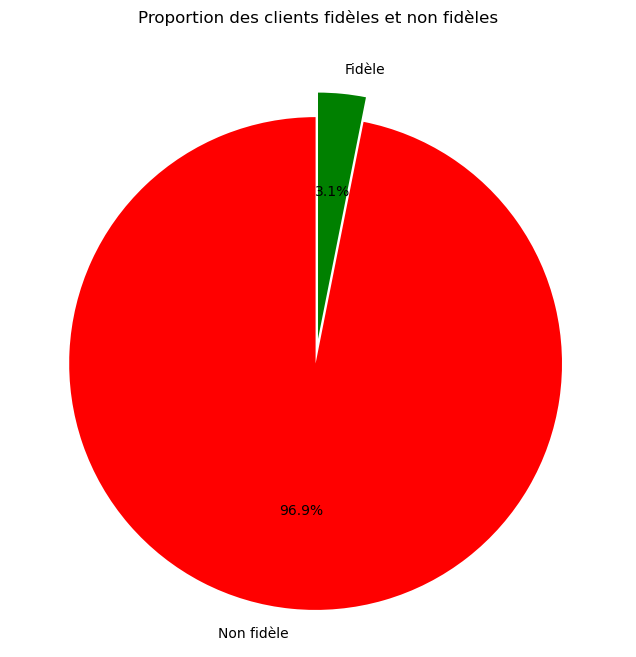

In [57]:
# Proportion des clients fidèles et non fidèles
loyalty_counts = customer_orders['order_count'].apply(lambda x: 'Fidèle' if x > 1 else 'Non fidèle').value_counts()

plt.figure(figsize=(8, 8))
loyalty_counts.plot.pie(autopct='%1.1f%%', colors=['red', 'green'], startangle=90, explode=[0.1, 0])
plt.title("Proportion des clients fidèles et non fidèles")
plt.ylabel("")
plt.show()

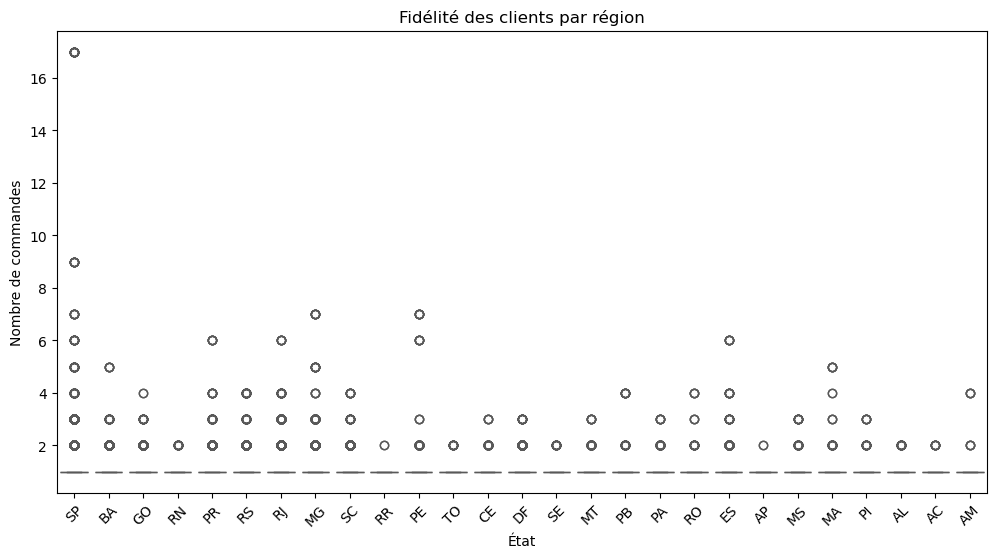

In [58]:
# Fidélité des clients par région
plt.figure(figsize=(12, 6))
sns.boxplot(x='state', y='order_count', data=df_analyse_ventes, palette="Set2")
plt.title("Fidélité des clients par région")
plt.xlabel("État")
plt.ylabel("Nombre de commandes")
plt.xticks(rotation=45)
plt.show()

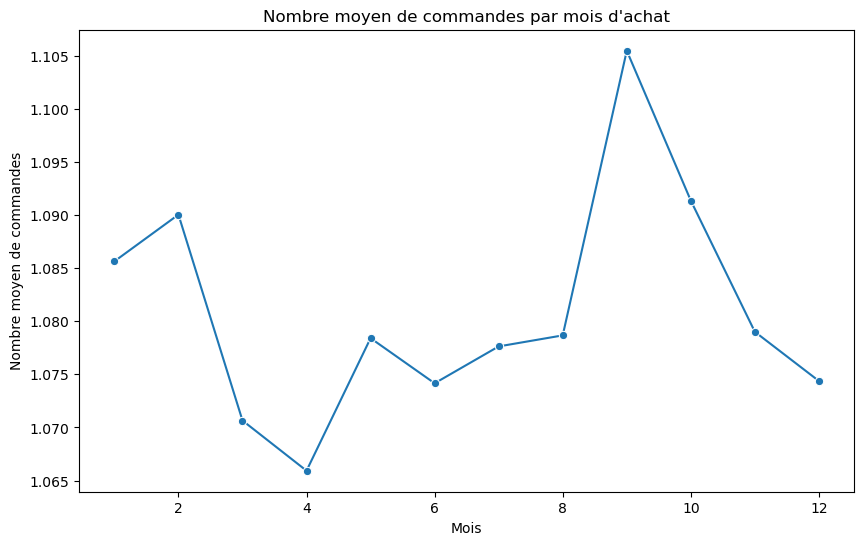

In [59]:
# Nombre moyen de commandes par mois d'achat
df_analyse_ventes['month'] = df_analyse_ventes['purchase_timestamp'].dt.month
monthly_orders = df_analyse_ventes.groupby('month')['order_count'].mean()

plt.figure(figsize=(10, 6))
sns.lineplot(x=monthly_orders.index, y=monthly_orders.values, marker="o")
plt.title("Nombre moyen de commandes par mois d'achat")
plt.xlabel("Mois")
plt.ylabel("Nombre moyen de commandes")
plt.show()

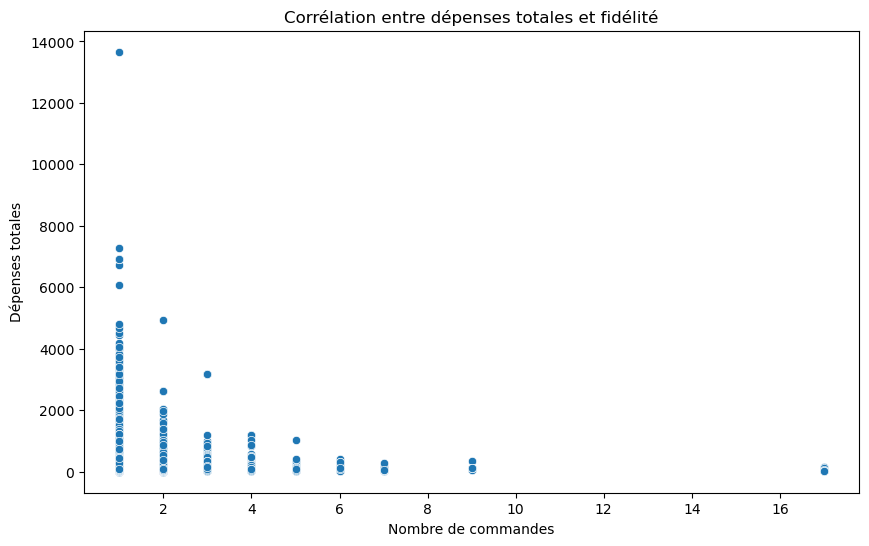

In [60]:
# Corrélation entre dépenses totales et fidélité
df_analyse_ventes['total_spent'] = df_analyse_ventes[
    ['value_boleto', 'value_credit_card', 'value_debit_card', 'value_voucher']
].sum(axis=1)

plt.figure(figsize=(10, 6))
sns.scatterplot(x='order_count', y='total_spent', data=df_analyse_ventes)
plt.title("Corrélation entre dépenses totales et fidélité")
plt.xlabel("Nombre de commandes")
plt.ylabel("Dépenses totales")
plt.show()

In [61]:
# Afficher les clients ayant dépensé le plus
top_spenders = df_analyse_ventes[['customer_unique_id', 'order_count', 'total_spent']].sort_values(by='total_spent', ascending=False).head(10)
top_spenders

customer_unique_id  order_count  total_spent
13390  0a0a92112bd4c708ca5fde585afaa872            1     13664.08
66599  763c8b1c9c68a0229c42c9fc6f662b93            1      7274.88
22171  dc4802a71eae9be1dd28f5d788ceb526            1      6929.31
28326  459bef486812aa25204be022145caa62            1      6922.21
3508   ff4159b92c40ebe40454e3e6a7c35ed6            1      6726.66
32322  4007669dec559734d6f53e029e360987            1      6081.54
53352  da122df9eeddfedc1dc1f5349a1a690c            2      4950.34
41086  5d0a2980b292d049061542014e8960bf            1      4809.44
40327  eebb5dda148d3893cdaf5b5ca3040ccb            1      4764.34
40342  48e1ac109decbb87765a3eade6854098            1      4681.78

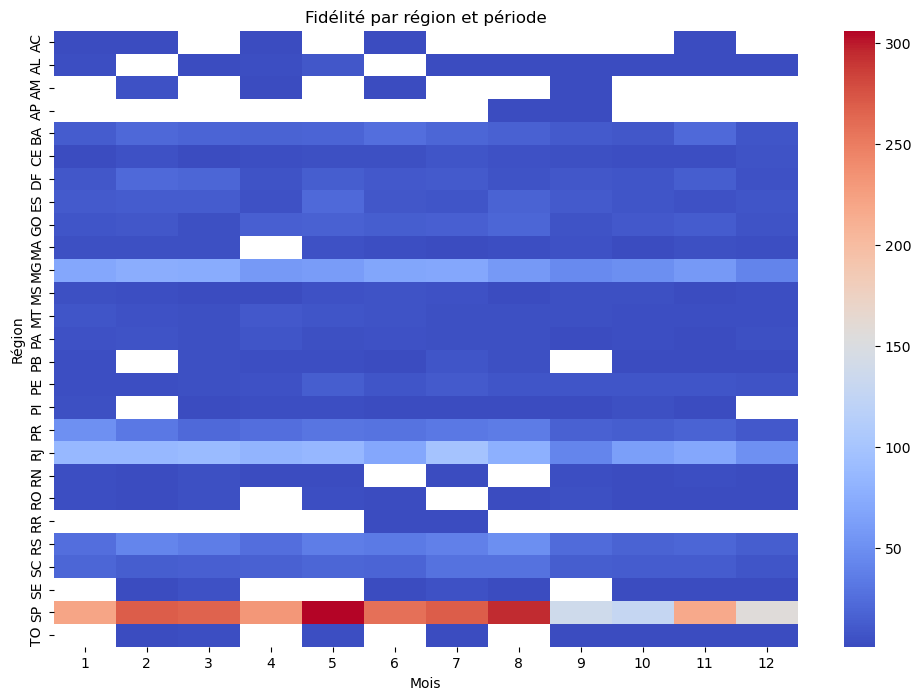

In [62]:
# Fidélité par région et période
region_month_loyalty = df_analyse_ventes[df_analyse_ventes['order_count'] > 1].groupby(['state', 'month']).size().unstack()

plt.figure(figsize=(12, 8))
sns.heatmap(region_month_loyalty, cmap="coolwarm", annot=False, cbar=True)
plt.title("Fidélité par région et période")
plt.xlabel("Mois")
plt.ylabel("Région")
plt.show()

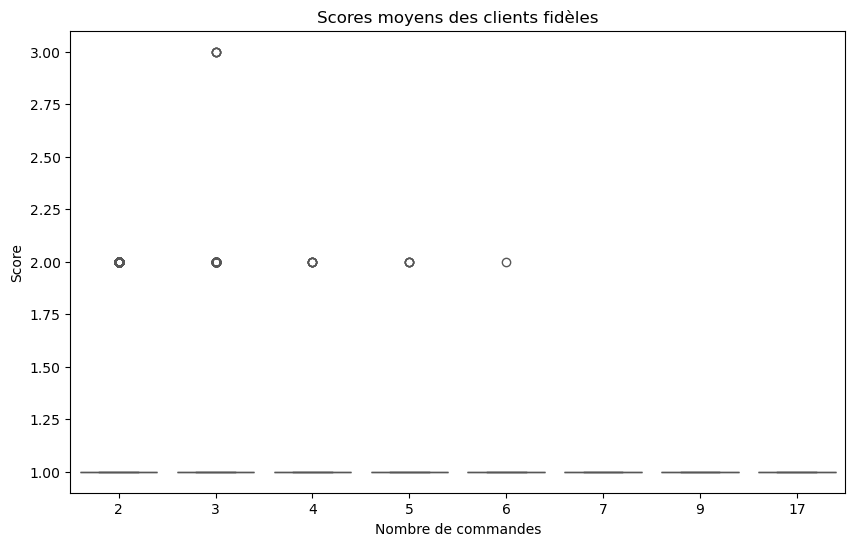

In [63]:
# Scores moyens des clients fidèles
plt.figure(figsize=(10, 6))
sns.boxplot(x='order_count', y='score', data=df_analyse_ventes[df_analyse_ventes['order_count'] > 1], palette="coolwarm")
plt.title("Scores moyens des clients fidèles")
plt.xlabel("Nombre de commandes")
plt.ylabel("Score")
plt.show()

In [64]:
score_max = df_analyse_ventes['score'].max()
score_max

3

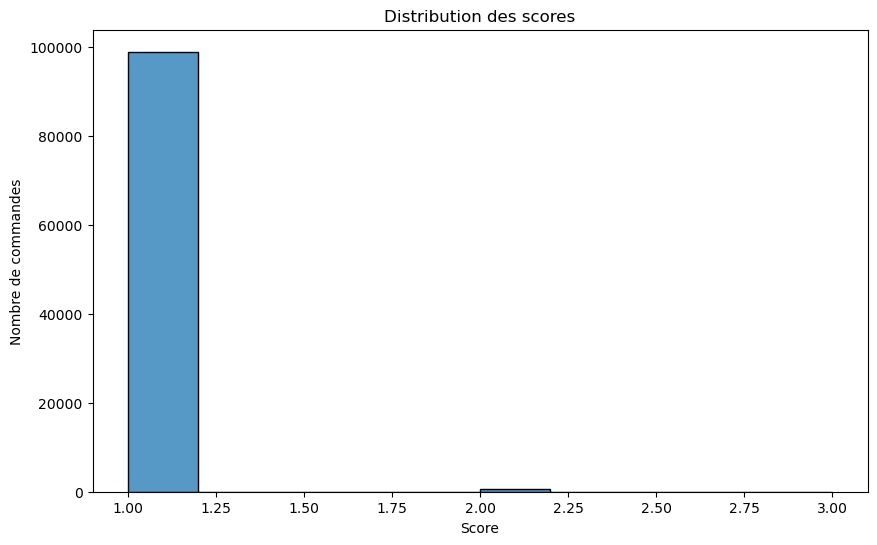

In [176]:
# Distribution des scores dans le dataset
plt.figure(figsize=(10, 6))
sns.histplot(df_analyse_ventes['score'], bins=10, kde=False)
plt.title("Distribution des scores")
plt.xlabel("Score")
plt.ylabel("Nombre de commandes")
plt.show()

## Conclusion

La plus grande majorité des clients dans les données n'ont commandé qu'une fois. (presque 100k)
La proportion des clients ayant commandé plusieurs fois, les clients fidèles est de 3.1%.
Encore une fois on retrouve au sommet des regions ayant des acheteurs fidèles, Sao Paulo (SP), Rio de Janeiro (RJ) et de Minas Gerais (MG) ainsi que Pernambuco (PE). Un client de SP a passsé 17 commandes.
Les mois les plus propices aux commandes sont les mois d'hiver (également les mois avec les temps de livraisons moyes les plus longs).
La personne ayant passé 16 commandes a passé des commandes à moins de 2000 réal brésilien à chaque fois. Un client a passé une commande de plus de 13664 réal brésilien (2 273€), sachant que le salaire moyen brésilien annuel est de 6500€, cela représente une belle somme.
La région la plus fidèle est Sao Paulo.
La note mise par les clients fidèle est souvent 2 sur 3.

## 2. QUESTION 2 : Quels modes de paiement sont les plus populaires ?

In [68]:
payment_modes = df_analyse_ventes[['int_boleto', 'int_credit_card', 'int_debit_card', 'int_voucher', 'int_not_defined']].sum()
payment_modes = payment_modes.rename(index={
    'int_boleto': 'Boleto',
    'int_credit_card': 'Carte de crédit',
    'int_debit_card': 'Carte de débit',
    'int_voucher': 'Voucher',
    'int_not_defined': 'Non défini'
})

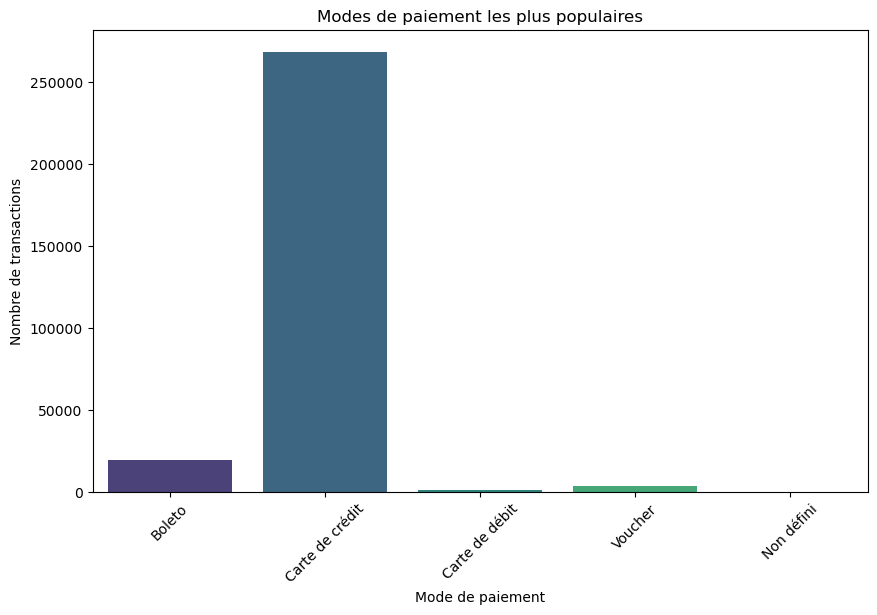

In [69]:
# Modes de paiement les plus populaires
plt.figure(figsize=(10, 6))
sns.barplot(x=payment_modes.index, y=payment_modes.values, palette="viridis")
plt.title("Modes de paiement les plus populaires")
plt.xlabel("Mode de paiement")
plt.ylabel("Nombre de transactions")
plt.xticks(rotation=45)
plt.show()

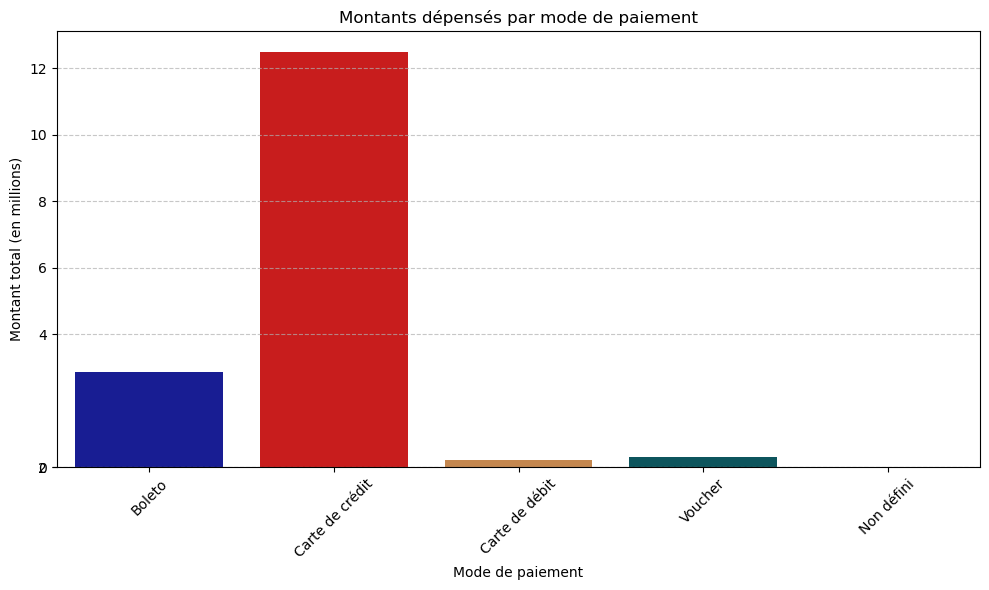

In [70]:
# Montants dépensés par mode de paiement
payment_values = df_analyse_ventes[['value_boleto', 'value_credit_card', 'value_debit_card', 'value_voucher', 'value_not_defined']].sum()
payment_values = payment_values.rename(index={
    'value_boleto': 'Boleto',
    'value_credit_card': 'Carte de crédit',
    'value_debit_card': 'Carte de débit',
    'value_voucher': 'Voucher',
    'value_not_defined': 'Non défini'
})

plt.figure(figsize=(10, 6))
sns.barplot(x=payment_values.index, y=payment_values.values, palette=palette)

plt.title("Montants dépensés par mode de paiement")
plt.xlabel("Mode de paiement")
plt.ylabel("Montant total (en millions)")
plt.xticks(rotation=45)
plt.yticks(
    ticks=[0, 0.2, 4e6, 6e6, 8e6, 10e6, 12e6],
    labels=["0", "2", "4", "6", "8", "10", "12"]
)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

<Figure size 1200x600 with 0 Axes>

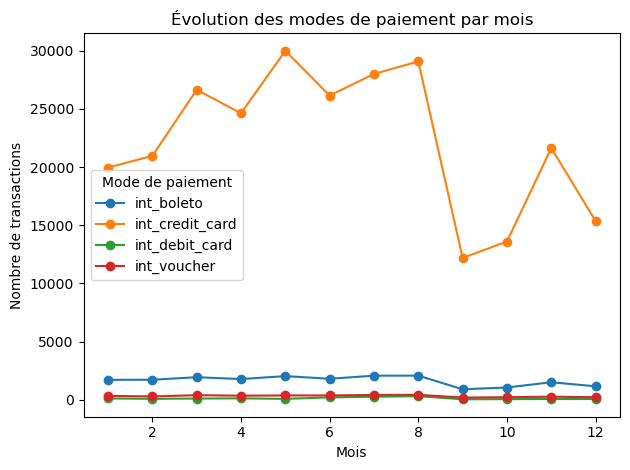

In [71]:
# Évolution des modes de paiement par mois
df_analyse_ventes['month'] = df_analyse_ventes['purchase_timestamp'].dt.month
monthly_payment_modes = df_analyse_ventes.groupby('month')[['int_boleto', 'int_credit_card', 'int_debit_card', 'int_voucher']].sum()

plt.figure(figsize=(12, 6))
monthly_payment_modes.plot(kind='line', marker='o')
plt.title("Évolution des modes de paiement par mois")
plt.xlabel("Mois")
plt.ylabel("Nombre de transactions")
plt.legend(title="Mode de paiement")
plt.tight_layout()
plt.show()

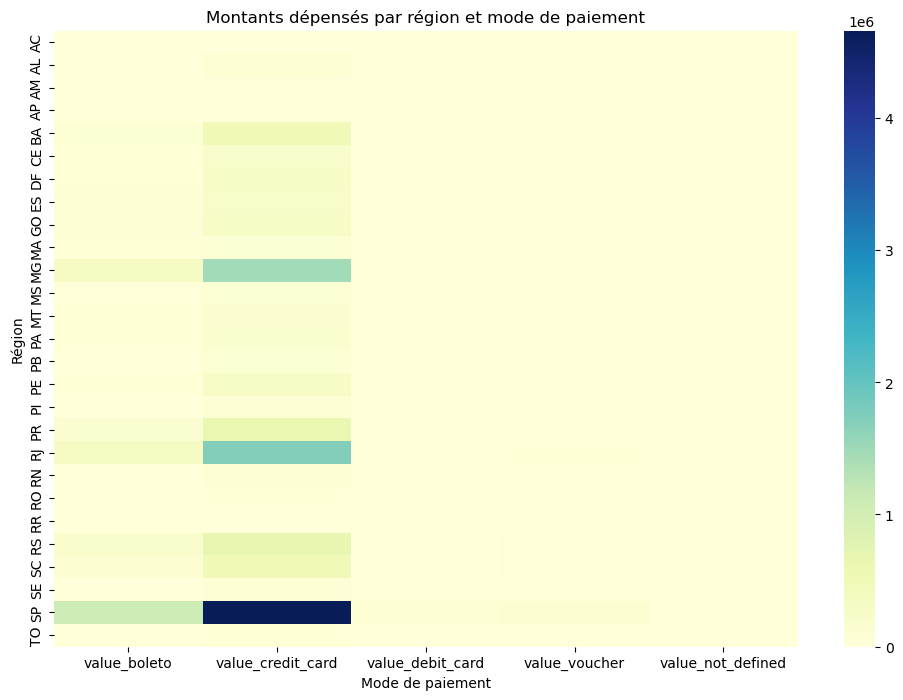

In [72]:
# Montants dépensés par région et mode de paiement
region_payment_values = df_analyse_ventes.groupby('state')[
    ['value_boleto', 'value_credit_card', 'value_debit_card', 'value_voucher', 'value_not_defined']
].sum()

plt.figure(figsize=(12, 8))
sns.heatmap(region_payment_values, annot=False, fmt='.0f', cmap="YlGnBu")
plt.title("Montants dépensés par région et mode de paiement")
plt.xlabel("Mode de paiement")
plt.ylabel("Région")
plt.show()

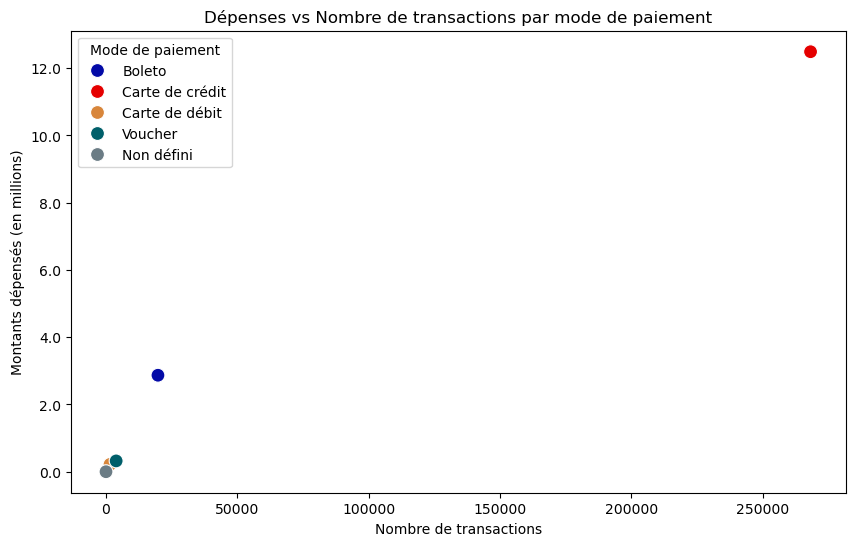

In [73]:
# Dépenses vs Nombre de transactions par mode de paiement
plt.figure(figsize=(10, 6))
sns.scatterplot(x=payment_modes.values, y=payment_values.values, hue=payment_modes.index, palette=palette, s=100)
plt.title("Dépenses vs Nombre de transactions par mode de paiement")
plt.xlabel("Nombre de transactions")
plt.ylabel("Montants dépensés (en millions)")
plt.legend(title="Mode de paiement")
plt.gca().yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f'{x/1e6:.1f}'))
plt.show()

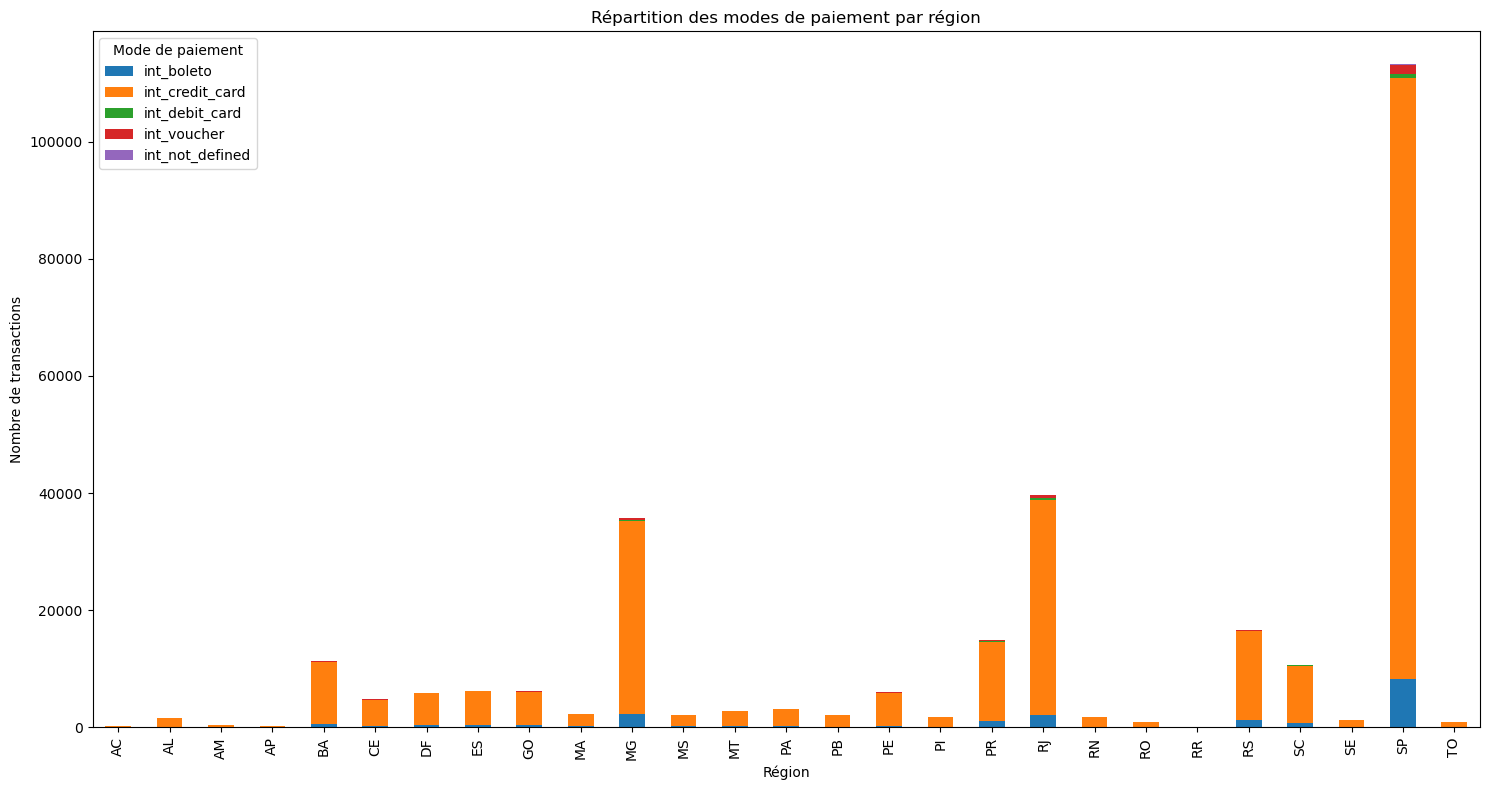

In [74]:
# Répartition des modes de paiement par région
region_payment_modes = df_analyse_ventes.groupby('state')[
    ['int_boleto', 'int_credit_card', 'int_debit_card', 'int_voucher', 'int_not_defined']
].sum()

region_payment_modes.plot(kind='bar', stacked=True, figsize=(15, 8))
plt.title("Répartition des modes de paiement par région")
plt.xlabel("Région")
plt.ylabel("Nombre de transactions")
plt.legend(title="Mode de paiement")
plt.tight_layout()
plt.show()

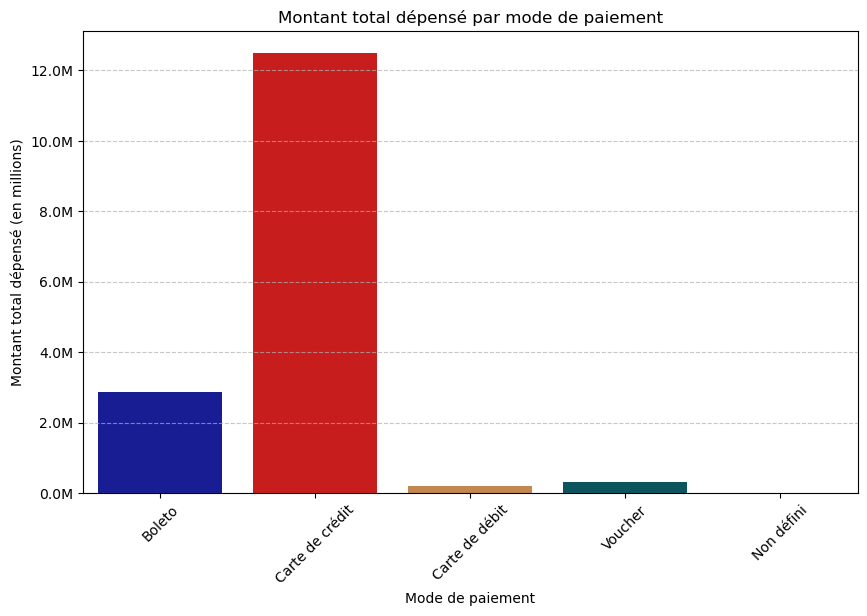

In [75]:
# Montant total dépensé par mode de paiement
total_spent_per_payment = df_analyse_ventes[['value_boleto', 'value_credit_card', 'value_debit_card', 'value_voucher', 'value_not_defined']].sum()
total_spent_per_payment = total_spent_per_payment.rename(index={
    'value_boleto': 'Boleto',
    'value_credit_card': 'Carte de crédit',
    'value_debit_card': 'Carte de débit',
    'value_voucher': 'Voucher',
    'value_not_defined': 'Non défini'
})

plt.figure(figsize=(10, 6))
sns.barplot(x=total_spent_per_payment.index, y=total_spent_per_payment.values, palette=palette)

plt.title("Montant total dépensé par mode de paiement")
plt.xlabel("Mode de paiement")
plt.ylabel("Montant total dépensé (en millions)")
plt.xticks(rotation=45)

plt.gca().yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f'{x/1e6:.1f}M'))

plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

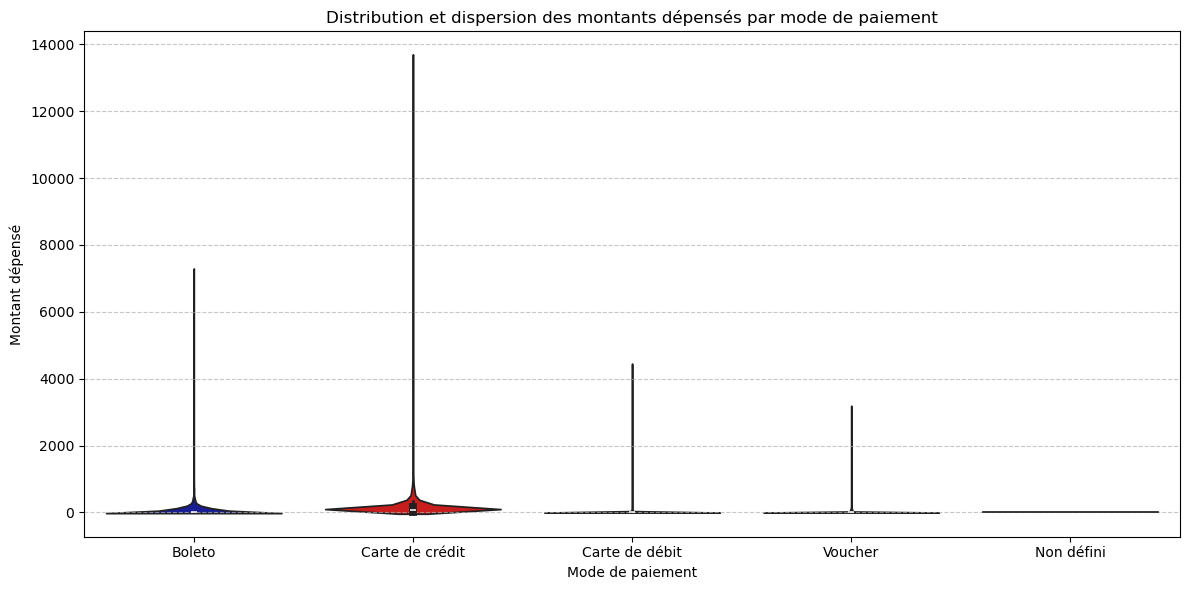

In [76]:
# Distribution et dispersion des montants dépensés par mode de paiement
plt.figure(figsize=(12, 6))
sns.violinplot(
    data=df_analyse_ventes[['value_boleto', 'value_credit_card', 'value_debit_card', 'value_voucher', 'value_not_defined']],
    palette=palette
)
plt.title("Distribution et dispersion des montants dépensés par mode de paiement")
plt.xlabel("Mode de paiement")
plt.ylabel("Montant dépensé")
plt.xticks(ticks=range(5), labels=payment_values.index)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

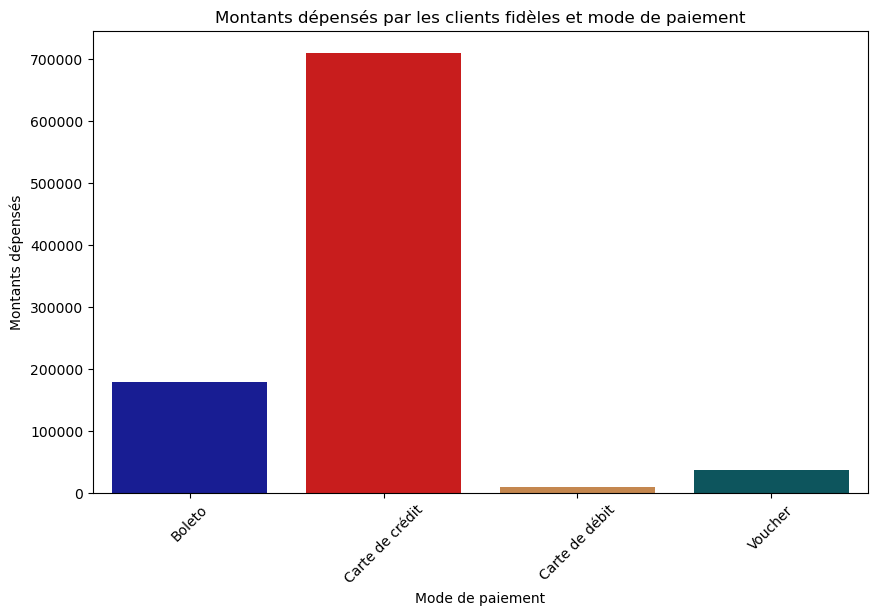

In [77]:
# Montants dépensés par les clients fidèles et mode de paiement
loyal_customers = df_analyse_ventes[df_analyse_ventes['order_count'] > 1]
loyal_payment_values = loyal_customers[['value_boleto', 'value_credit_card', 'value_debit_card', 'value_voucher']].sum()
loyal_payment_values = loyal_payment_values.rename(index={
    'value_boleto': 'Boleto',
    'value_credit_card': 'Carte de crédit',
    'value_debit_card': 'Carte de débit',
    'value_voucher': 'Voucher',
})

plt.figure(figsize=(10, 6))
sns.barplot(x=loyal_payment_values.index, y=loyal_payment_values.values, palette=palette)
plt.title("Montants dépensés par les clients fidèles et mode de paiement")
plt.xlabel("Mode de paiement")
plt.ylabel("Montants dépensés")
plt.xticks(rotation=45)
plt.show()

In [78]:
# Transactions les plus élevées par mode de paiement
high_transactions = df_analyse_ventes[['value_boleto', 'value_credit_card', 'value_debit_card', 'value_voucher', 'value_not_defined']].max()
print(high_transactions)

value_boleto          7274.88
value_credit_card    13664.08
value_debit_card      4445.50
value_voucher         3184.34
value_not_defined        0.00
dtype: float64


## Conclusion

Le moyen de paiement le plus populaire est la carte de crédit, suivi de très très loin par le Boleto. La carte de crédit traite jusqu'à 12 millions de réals brésilien de commandes. Boleto en traite 3 millions uniquement.
Le nombre de transactions est elevé pendant la belle saison et chutent en septembre, pour reprendre vers la fin de l'année.
Le plus de transactions carte de créit ont lieu dans les 3 régions Sao Paulo (SP), Rio de Janeiro (RJ) et de Minas Gerais (MG)

## 3. QUESTION 3 : Quels facteurs influencent le taux d'annulation des commandes ?

In [81]:
# Nombre total de commandes
total_orders = df_analyse_ventes.shape[0]

# Nombre de commandes annulées
canceled_orders = df_analyse_ventes[df_analyse_ventes['status'] == 'canceled'].shape[0]

print(f"Nombre total de commandes : {total_orders}")
print(f"Nombre de commandes annulées : {canceled_orders}")

# Calcul du taux d'annulation
cancellation_rate = (canceled_orders / total_orders) * 100
print(f"Taux d'annulation : {cancellation_rate:.2f}%")


Nombre total de commandes : 99441
Nombre de commandes annulées : 625
Taux d'annulation : 0.63%


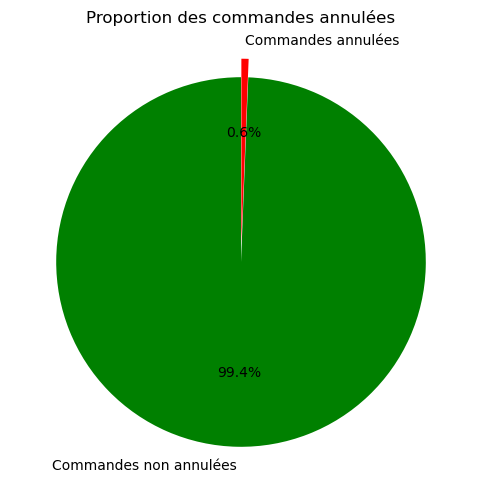

In [82]:
# Visualisation de la proportion des commandes annulées
labels = ['Commandes non annulées', 'Commandes annulées']
sizes = [total_orders - canceled_orders, canceled_orders]
colors = ['green', 'red']

plt.figure(figsize=(8, 6))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', colors=colors, startangle=90, explode=[0, 0.1])
plt.title("Proportion des commandes annulées")
plt.show()

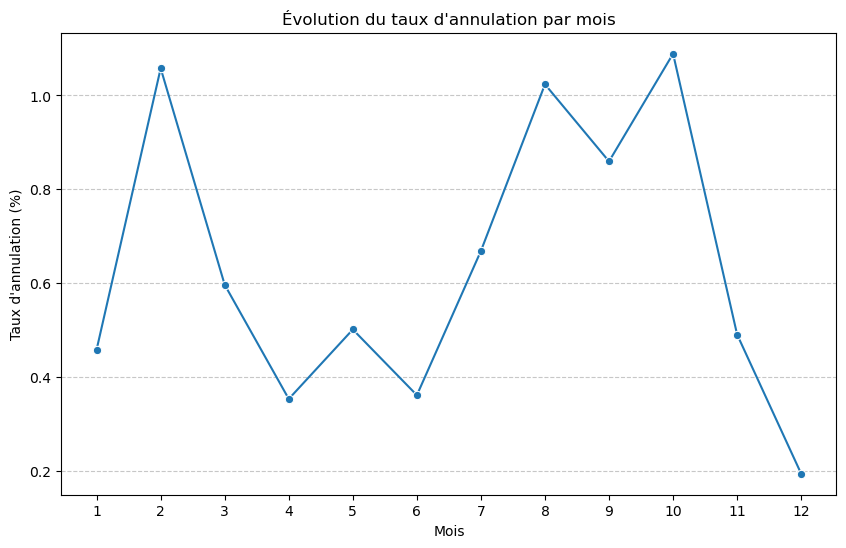

In [83]:
# Extraire le mois des commandes
df_analyse_ventes['month'] = df_analyse_ventes['purchase_timestamp'].dt.month

# Calcul du taux d'annulation par mois
monthly_cancellations = df_analyse_ventes[df_analyse_ventes['status'] == 'canceled'].groupby('month').size()
monthly_orders = df_analyse_ventes.groupby('month').size()
cancellation_rate = (monthly_cancellations / monthly_orders).fillna(0) * 100

# Tracer l'évolution du taux d'annulation
plt.figure(figsize=(10, 6))
sns.lineplot(x=cancellation_rate.index, y=cancellation_rate.values, marker="o")
plt.title("Évolution du taux d'annulation par mois")
plt.xlabel("Mois")
plt.ylabel("Taux d'annulation (%)")
plt.xticks(range(1, 13))
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

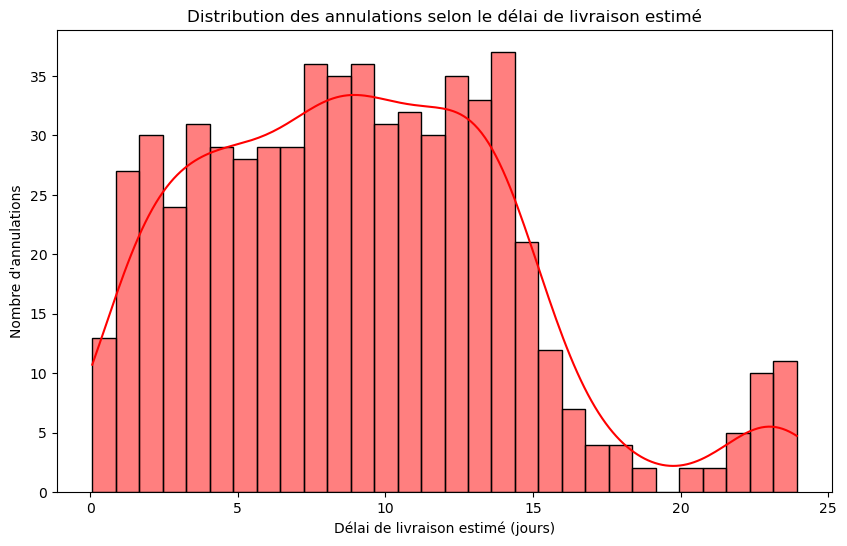

In [84]:
plt.figure(figsize=(10, 6))
sns.histplot(
    df_analyse_ventes[df_analyse_ventes['status'] == 'canceled']['estimee'],
    bins=30, kde=True, color="red"
)
plt.title("Distribution des annulations selon le délai de livraison estimé")
plt.xlabel("Délai de livraison estimé (jours)")
plt.ylabel("Nombre d'annulations")
plt.show()

<Figure size 1200x800 with 0 Axes>

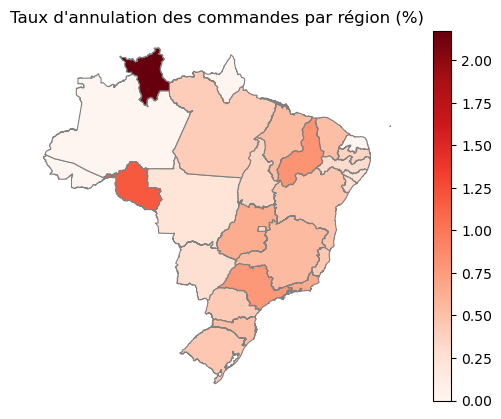

In [85]:
# Taux d'annulation des commandes par région (%)
df_analyse_ventes['state_name'] = df_analyse_ventes['state'].map(state_code_map)

region_cancellations = df_analyse_ventes[df_analyse_ventes['status'] == 'canceled'].groupby('state_name').size()
region_orders = df_analyse_ventes.groupby('state_name').size()
cancellation_rate = (region_cancellations / region_orders).fillna(0) * 100

url_geojson = "https://raw.githubusercontent.com/codeforgermany/click_that_hood/master/public/data/brazil-states.geojson"
brazil_map = gpd.read_file(url_geojson)

brazil_map = brazil_map.merge(cancellation_rate.reset_index(), left_on="name", right_on="state_name", how="left")

plt.figure(figsize=(12, 8))
brazil_map.plot(column=0, cmap='Reds', linewidth=0.8, edgecolor='grey', legend=True)
plt.title("Taux d'annulation des commandes par région (%)")
plt.axis("off")
plt.show()

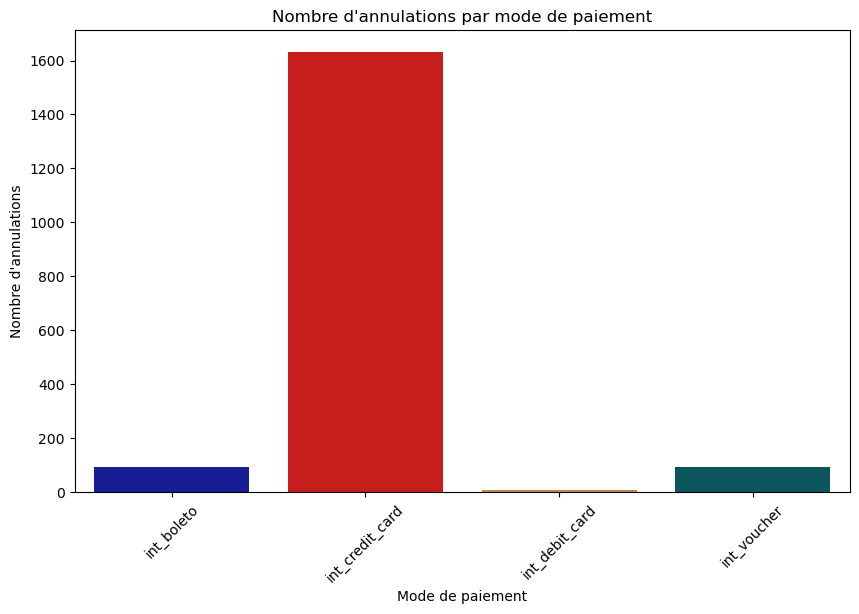

In [86]:
# Nombre d'annulations par mode de paiement
payment_cancellations = df_analyse_ventes[df_analyse_ventes['status'] == 'canceled'][
    ['int_boleto', 'int_credit_card', 'int_debit_card', 'int_voucher']
].sum()

plt.figure(figsize=(10, 6))
sns.barplot(x=payment_cancellations.index, y=payment_cancellations.values, palette=palette)
plt.title("Nombre d'annulations par mode de paiement")
plt.xlabel("Mode de paiement")
plt.ylabel("Nombre d'annulations")
plt.xticks(rotation=45)
plt.show()

In [87]:
# Je me suis rendu compte que 1600 commandes annulées était supérieur au nombre de commandes totales annulées (625), 
# j'ai donc cherché pourquoi c'était le cas, est-ce qu'il y a plusieurs moyens de paiement utilisés pour des commandes et comptées ici ?

# Visualisation de commandes utilisant plusieurs moyens de paiement
df_analyse_ventes[df_analyse_ventes['status'] == 'canceled'][['int_boleto', 'int_credit_card', 'int_debit_card', 'int_voucher']].head(10)

int_boleto  int_credit_card  int_debit_card  int_voucher
397          1.0              0.0             0.0          0.0
613          0.0              4.0             0.0          0.0
1058         0.0              1.0             0.0          1.0
1130         0.0              0.0             0.0          0.0
1801         0.0              0.0             0.0          1.0
1811         0.0              5.0             0.0          0.0
1819         1.0              0.0             0.0          0.0
1868         1.0              0.0             0.0          0.0
1971         0.0              4.0             0.0          0.0
2029         0.0              0.0             0.0          1.0

In [88]:
# Nombre de commandes utilisant plusieurs moyens de paiement
df_analyse_ventes[df_analyse_ventes['status'] == 'canceled'][['int_boleto', 'int_credit_card', 'int_debit_card', 'int_voucher']].sum(axis=1).value_counts()

# Oui il y a effectivement plusieurs moyens de paiement utilisés dans le diagramme "Nombre d'annulations par mode de paiement"

1.0     307
2.0      71
3.0      70
4.0      43
10.0     35
5.0      30
8.0      29
6.0      21
7.0       7
9.0       6
0.0       3
11.0      2
13.0      1
Name: count, dtype: int64

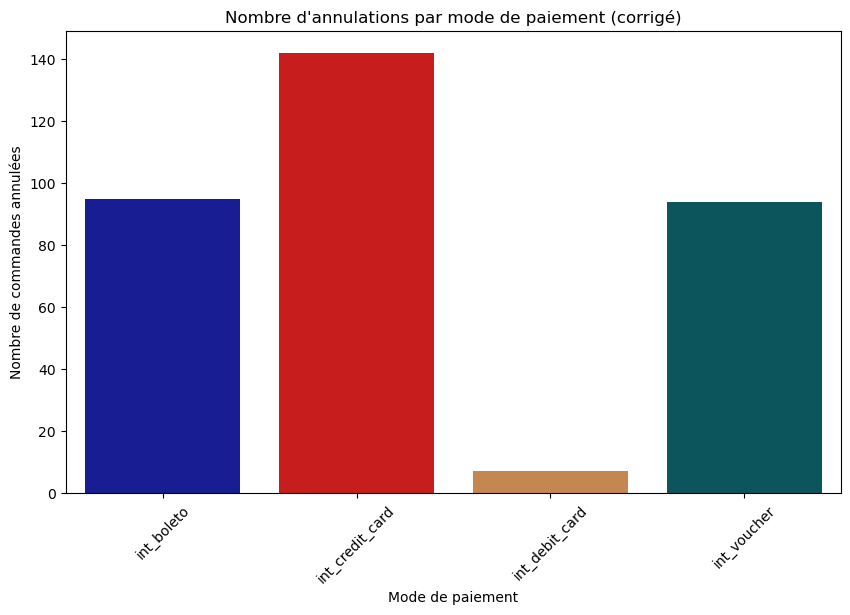

In [89]:
# Nombre d'annulations par mode de paiement (version corrigée)
payment_cancellations = df_analyse_ventes[df_analyse_ventes['status'] == 'canceled'][
    ['order_id', 'int_boleto', 'int_credit_card', 'int_debit_card', 'int_voucher']
].melt(id_vars='order_id', var_name='payment_method', value_name='used')

payment_cancellations = payment_cancellations[payment_cancellations['used'] == 1]
payment_cancellations = payment_cancellations.groupby('payment_method')['order_id'].nunique()

plt.figure(figsize=(10, 6))
sns.barplot(x=payment_cancellations.index, y=payment_cancellations.values, palette=palette)
plt.title("Nombre d'annulations par mode de paiement (corrigé)")
plt.xlabel("Mode de paiement")
plt.ylabel("Nombre de commandes annulées")
plt.xticks(rotation=45)
plt.show()

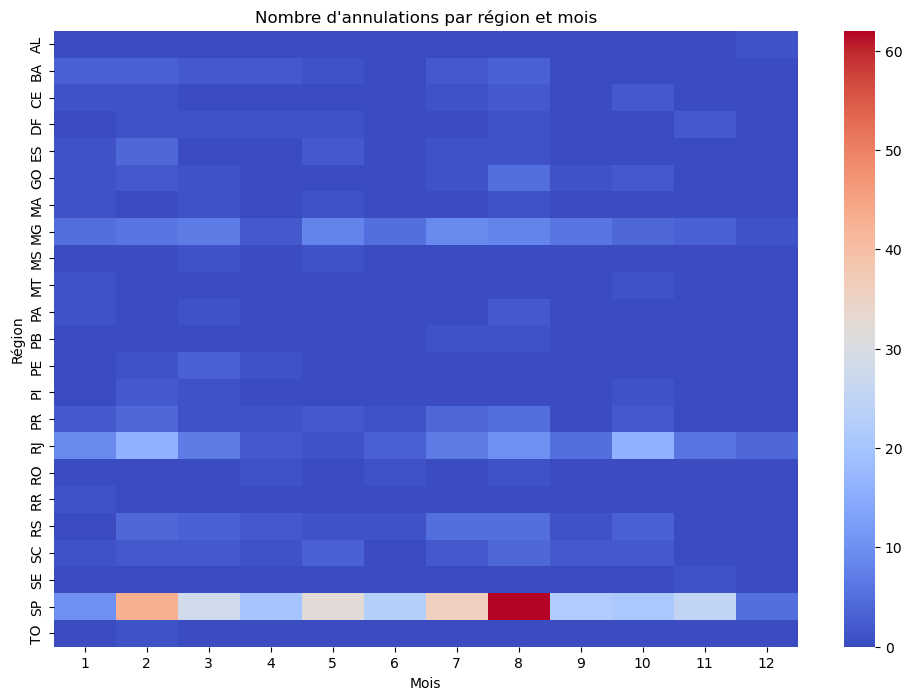

In [90]:
# Nombre d'annulations par région et mois
region_month_cancellations = df_analyse_ventes[df_analyse_ventes['status'] == 'canceled'].groupby(['state', 'month']).size().unstack().fillna(0)

plt.figure(figsize=(12, 8))
sns.heatmap(region_month_cancellations, cmap="coolwarm", annot=False, cbar=True)
plt.title("Nombre d'annulations par région et mois")
plt.xlabel("Mois")
plt.ylabel("Région")
plt.show()

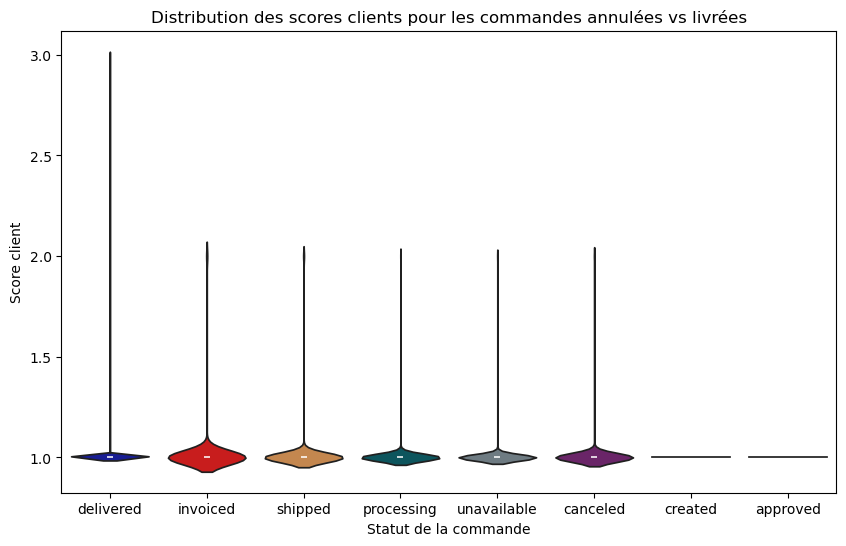

In [91]:
# Distribution des scores clients pour les commandes annulées vs livrées
plt.figure(figsize=(10, 6))
sns.violinplot(x='status', y='score', data=df_analyse_ventes, palette=palette)
plt.title("Distribution des scores clients pour les commandes annulées vs livrées")
plt.xlabel("Statut de la commande")
plt.ylabel("Score client")
plt.show()

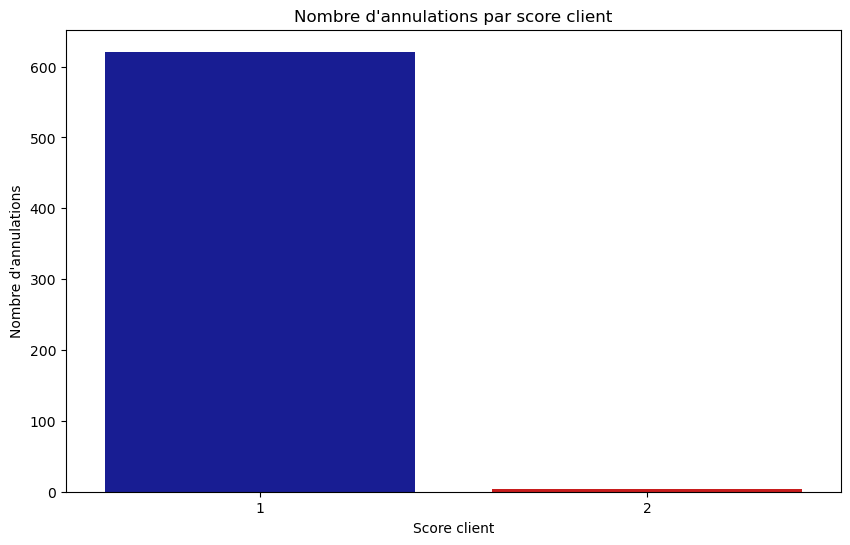

In [92]:
# Nombre d'annulations en fonction du score du score client
score_cancellations = df_analyse_ventes[df_analyse_ventes['status'] == 'canceled'].groupby('score').size()

plt.figure(figsize=(10, 6))
sns.barplot(x=score_cancellations.index, y=score_cancellations.values, palette=palette)
plt.title("Nombre d'annulations par score client")
plt.xlabel("Score client")
plt.ylabel("Nombre d'annulations")
plt.show()

CONCLUSION TODO